## Business Analytics Online


# Healthcare and Medical Analytics

## Group assignment: Documenting a health challenge using analytics 
This Jupyter notebook is an appendix to group 5's submission. 
<br>
For more context & references please consult the main report.
<br>
<br>

Name |CID
:----|:----
Knud Erik Guldbaek Arentsen|01766801
Jean-Luc Kyburz|01609836
Jasper Wouters|01805573
Florence Yeung|00972048
Shang Zhang |01816154

---


## Imports & formatting

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import statsmodels.api as sm

from IPython.display import display, Markdown
from collections import OrderedDict

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_score, accuracy_score, recall_score
from sklearn import metrics
from sklearn.dummy import DummyClassifier
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier

from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE

In [12]:
from IPython.core.display import HTML as Center

Center(""" <style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style> """)

In [13]:
# Global variables
path = './'

## Load & clean data

Skip this section in case you already have final output file `merged_df.csv`. This one can be loaded directly in the [Feature engineering](#feature_engineering) section.

### Patients & admissions

In [15]:
# Load data
patients_df = pd.read_csv(path+'PATIENTS.csv')
admissions_df = pd.read_csv(path+'ADMISSIONS.csv')

In [16]:
# Merge
admissions_df = admissions_df.merge(patients_df, on='SUBJECT_ID')

In [17]:
# Drop columns not needed
admissions_df = admissions_df.drop(['EDREGTIME', 'EDOUTTIME', 'ROW_ID_y', 'DOD_HOSP', 'DOD_SSN', 'EXPIRE_FLAG'], axis=1)

In [18]:
# Convert to date
admissions_df['ADMITTIME'] = pd.to_datetime(admissions_df['ADMITTIME'], errors='coerce')
admissions_df['DISCHTIME'] = pd.to_datetime(admissions_df['DISCHTIME'], errors='coerce')
admissions_df['DOB'] = pd.to_datetime(admissions_df['DOB'], errors='coerce')
admissions_df['DOD'] = pd.to_datetime(admissions_df['DOD'], errors='coerce')

In [19]:
# Export to file
admissions_df.to_csv('admissions_df.csv')

### Chart events

In [ ]:
# Process chart events data (iterative read because of large file size)
items_df = pd.read_csv(path+"D_ITEMS_filtered.csv")

idxs = list(zip(items_df.ITEMID.values))

chunk_list=[]
for chunk in pd.read_csv("C:\\Users\\jaspe\\Documents\\CHARTEVENTS.csv", chunksize=10000):
    chunk_list.append(chunk[pd.Series(list(zip(chunk.ITEMID)), index=chunk.index).isin(idxs)])

chartevents_df = pd.concat(chunk_list)

In [ ]:
# Filter out errors. Warnings should be kept: 
# https://opendata.stackexchange.com/questions/8974/want-to-understand-mimic-iii-warning-in-table-chartevents/9072
chartevents_df = chartevents_df[chartevents_df['ERROR'] == 0]

In [ ]:
# Convert to date
chartevents_df['CHARTTIME'] = pd.to_datetime(chartevents_df['CHARTTIME'], errors='coerce')
chartevents_df['STORETIME'] = pd.to_datetime(chartevents_df['STORETIME'], errors='coerce')

In [ ]:
# Group by admission, subject, ICU stay and item
chartevents_df = chartevents_df.set_index('CHARTTIME').groupby(['HADM_ID','SUBJECT_ID','ICUSTAY_ID','ITEMID'])

# Resample to hourly frequency
chartevents_df = chartevents_df.resample('H').agg({'VALUENUM':'mean',
                                                   'VALUEUOM':'first'}).reset_index()

In [ ]:
# rename columns
def rename(col):
    if isinstance(col, tuple):
        col = '_'.join(str(c) for c in col)
    return col
chartevents_df.columns = map(rename, chartevents_df.columns)

chartevents_df = chartevents_df.rename(columns={'HADM_ID_': 'HADM_ID', 
                                                'SUBJECT_ID_': 'SUBJECT_ID', 
                                                'ICUSTAY_ID_': 'ICUSTAY_ID', 
                                                'ITEMID_': 'ITEMID', 
                                                'CHARTTIME_': 'CHARTTIME', 
                                                'VALUENUM': 'MEAN', 
                                                'VALUEUOM': 'UOM'})

In [ ]:
# rows to columns (pivot)
chartevents_df = chartevents_df.pivot_table(index=['HADM_ID','SUBJECT_ID','ICUSTAY_ID','CHARTTIME'], columns='ITEMID', values=['MEAN']).reset_index()

In [ ]:
# rename columns
def rename(col):
    if isinstance(col, tuple):
        col = '_'.join(str(c) for c in col[::-1])
    return col
chartevents_df.columns = map(rename, chartevents_df.columns)

chartevents_df = chartevents_df.rename(columns={'_HADM_ID': 'HADM_ID', 
                                    '_SUBJECT_ID': 'SUBJECT_ID', 
                                    '_ICUSTAY_ID': 'ICUSTAY_ID', 
                                    '_CHARTTIME': 'CHARTTIME'})

In [ ]:
# Export to file
chartevents_df.to_csv('chartevents_df.csv')

### Medical history

In [ ]:
# Process chart events data (iterative read because of large file size)
items_df = pd.read_csv(path+"D_ITEMS_medicalhistory.csv")

idxs = list(zip(items_df.ITEMID.values))

chunk_list=[]
for chunk in pd.read_csv("C:\\Users\\jaspe\\Documents\\CHARTEVENTS.csv", chunksize=10000):
    chunk_list.append(chunk[pd.Series(list(zip(chunk.ITEMID)), index=chunk.index).isin(idxs)])

medicalhistory_df = pd.concat(chunk_list)

In [ ]:
# Group by admission, subject, ICU stay and item
medicalhistory_df = medicalhistory_df.groupby(['HADM_ID','SUBJECT_ID','ICUSTAY_ID','ITEMID']).agg({'VALUE':'first'}).reset_index()

In [ ]:
# rows to columns (pivot)
medicalhistory_df = medicalhistory_df.pivot_table(index=['HADM_ID','SUBJECT_ID','ICUSTAY_ID'], columns='ITEMID', values=['VALUE'], aggfunc=lambda x: ' '.join(x)).reset_index()

In [ ]:
# rename columns
def rename(col):
    if isinstance(col, tuple):
        col = '_'.join(str(c) for c in col[::-1])
    return col
medicalhistory_df.columns = map(rename, medicalhistory_df.columns)

pivot_df = pivot_df.rename(columns={'_HADM_ID': 'HADM_ID', 
                                    '_SUBJECT_ID': 'SUBJECT_ID', 
                                    '_ICUSTAY_ID': 'ICUSTAY_ID'})

In [ ]:
# Export to file
medicalhistory_df.to_csv('medicalhistory_df.csv')

### Prescriptions

In [ ]:
# Load data
prescriptions_df = pd.read_csv(path+'PRESCRIPTIONS.csv')

In [ ]:
# Convert to date
prescriptions_df['STARTDATE'] = pd.to_datetime(prescriptions_df['STARTDATE'], errors='coerce')
prescriptions_df['ENDDATE'] = pd.to_datetime(prescriptions_df['ENDDATE'], errors='coerce')

In [ ]:
# Group by admission, subject, ICU stay and item + cumulative sum
prescriptions_df = prescriptions_df.groupby(['HADM_ID','SUBJECT_ID','ICUSTAY_ID','STARTDATE']).agg({'DRUG':'count'}).groupby(level=0).cumsum().reset_index()

In [ ]:
# Export to file
prescriptions_df.to_csv('prescriptions_df.csv')

### Services

In [ ]:
# Load data
services_df = pd.read_csv(path+'SERVICES.csv')

In [ ]:
# Convert to date
services_df['TRANSFERTIME'] = pd.to_datetime(services_df['TRANSFERTIME'], errors='coerce')

In [ ]:
# Group by admission, subject + cumulative sum
services_df['SERVICES'] = services_df.groupby(['HADM_ID','SUBJECT_ID'])['CURR_SERVICE'].apply(lambda x: (x+',').cumsum()).apply(lambda x: x[:-1])
services_df['SERVICES'] = services_df['SERVICES'].apply(lambda x: ",".join(OrderedDict.fromkeys(x.split(','))))

In [ ]:
# Export to file
services_df.to_csv('services_df.csv')

## Prepare data set

We merge the data frames prepared above and filter for records related to the first 24 hours after admission

In [ ]:
# Merge admissions, chart events & medical history
merged_df = pd.read_csv(path+"chartevents_df.csv").merge(pd.read_csv(path+"admissions_df.csv"), how='left', on=['HADM_ID','SUBJECT_ID'])
merged_df = merged_df.merge(pd.read_csv(path+"medicalhistory_df.csv"), how='left', on=['HADM_ID','SUBJECT_ID','ICUSTAY_ID'])

In [ ]:
# Drop columns not needed or with too many missing values
merged_df = merged_df.drop(['Unnamed: 0_x'
                            ,'Unnamed: 0_y'
                            ,'ROW_ID_x'
                            ,'Unnamed: 0'], axis=1)

In [ ]:
# Convert to date
merged_df['CHARTTIME'] = pd.to_datetime(merged_df['CHARTTIME'], errors='coerce')
merged_df['ADMITTIME'] = pd.to_datetime(merged_df['ADMITTIME'], errors='coerce')
merged_df['DISCHTIME'] = pd.to_datetime(merged_df['DISCHTIME'], errors='coerce')
merged_df['DEATHTIME'] = pd.to_datetime(merged_df['DEATHTIME'], errors='coerce')
merged_df['DOD'] = pd.to_datetime(merged_df['DOD'], errors='coerce')
merged_df['DOB'] = pd.to_datetime(merged_df['DOB'], errors='coerce')

In [ ]:
# Add services
services_df = pd.read_csv(path+"services_df.csv")
services_df['TRANSFERTIME'] = pd.to_datetime(services_df['TRANSFERTIME'], errors='coerce')

merged_df = pd.merge(merged_df, services_df, how='left', on=['HADM_ID','SUBJECT_ID'])

merged_df['TRANSFERTIME'].fillna(value=pd.to_datetime('1/1/1980'), inplace=True)

index = (merged_df['TRANSFERTIME'] > merged_df['CHARTTIME'])
merged_df.loc[index ,'SERVICES'] = ''
merged_df.loc[index ,'TRANSFERTIME'] = pd.to_datetime('1/1/1980')

merged_df = merged_df[merged_df['TRANSFERTIME'] < merged_df['CHARTTIME']]
merged_df = merged_df.groupby(['HADM_ID','SUBJECT_ID','ICUSTAY_ID','CHARTTIME']).tail(1)

In [ ]:
# Add prescriptions
prescriptions_df = pd.read_csv(path+"prescriptions_df.csv")
prescriptions_df['STARTDATE'] = pd.to_datetime(prescriptions_df['STARTDATE'], errors='coerce')

merged_df = pd.merge(merged_df, prescriptions_df, how='left', on=['HADM_ID','SUBJECT_ID','ICUSTAY_ID'])

merged_df['STARTDATE'].fillna(value=pd.to_datetime('1/1/1980'), inplace=True)

index = (merged_df['STARTDATE'] > merged_df['CHARTTIME'])
merged_df.loc[index ,'DRUG'] = 0
merged_df.loc[index ,'STARTDATE'] = pd.to_datetime('1/1/1980')

merged_df = merged_df[merged_df['STARTDATE'] < merged_df['CHARTTIME']]
merged_df = merged_df.groupby(['HADM_ID','SUBJECT_ID','ICUSTAY_ID','CHARTTIME']).tail(1)

In [ ]:
# Calculate time since admission
merged_df['TIMESINCEADMISSION'] = merged_df['CHARTTIME'] - merged_df['ADMITTIME']

In [ ]:
# Filter for first 25 hours
merged_df = merged_df[(merged_df['TIMESINCEADMISSION'].dt.total_seconds() > 0) & (merged_df['TIMESINCEADMISSION'].dt.total_seconds() < 90000)]

In [ ]:
# Drop columns not needed
merged_df = merged_df.drop(['HAS_CHARTEVENTS_DATA', 'ROW_ID', 'TRANSFERTIME', 'PREV_SERVICE', 'CURR_SERVICE', 'STARTDATE'], axis=1)

In [ ]:
# Export to file
merged_df.to_csv('merged_df.csv')

<a id='feature_engineering'></a>
## Feature engineering


- In-hospital mortality
- Admission type (elective, urgent, emergency)
- Age
- Ethnicity
- Gender
- Insurance
- Language
- Marital status
- Religion
- Past medical history

- Chart events

- Prescriptions
- Diagnosis
- Services

In [14]:
# Load data
merged_df = pd.read_csv(path+'merged_df.csv')

# Convert to date
merged_df['CHARTTIME'] = pd.to_datetime(merged_df['CHARTTIME'], errors='coerce')
merged_df['ADMITTIME'] = pd.to_datetime(merged_df['ADMITTIME'], errors='coerce')
merged_df['DISCHTIME'] = pd.to_datetime(merged_df['DISCHTIME'], errors='coerce')
merged_df['DEATHTIME'] = pd.to_datetime(merged_df['DEATHTIME'], errors='coerce')
merged_df['DOD'] = pd.to_datetime(merged_df['DOD'], errors='coerce')
merged_df['DOB'] = pd.to_datetime(merged_df['DOB'], errors='coerce')

# Calculate time since admission
merged_df['TIMESINCEADMISSION'] = merged_df['CHARTTIME'] - merged_df['ADMITTIME']

### In-hospital mortality

In [15]:
# Target variable
merged_df = merged_df.rename(columns={'HOSPITAL_EXPIRE_FLAG': 'DEATH_IN_HOSPITAL'})

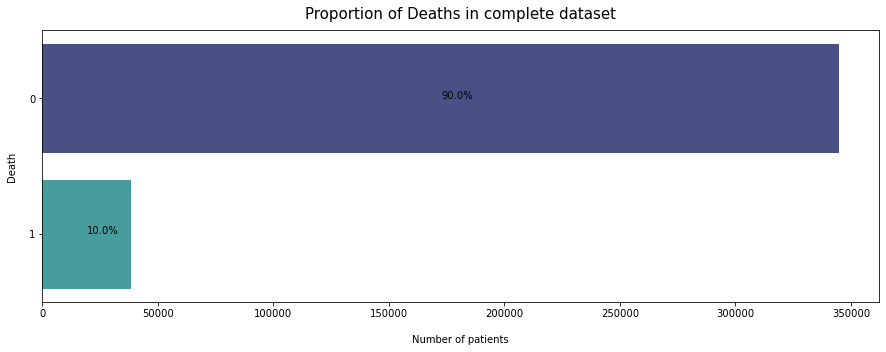

In [16]:
plt.figure(figsize=(15,5))

ax = sns.countplot(y="DEATH_IN_HOSPITAL", data=merged_df, order=[0,1], palette = 'mako', zorder = 1)
ax.set_xlabel('Number of patients', y = -0.4)
ax.set_ylabel('Death')
ax.xaxis.set_label_coords(0.5, -0.12)
ax.yaxis.set_label_coords(-0.03, 0.5)

total = len(merged_df['DEATH_IN_HOSPITAL'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width()/2
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y), size = 10)

plt.title('Proportion of Deaths in complete dataset', size = 15, y = 1.02)
plt.show()

In [17]:
merged_df['TIMETODEATH'] = merged_df['DOD'] - merged_df['ADMITTIME'].fillna(0)

In [18]:
pd.DataFrame(merged_df["TIMETODEATH"].describe()).rename(columns = {'TIMETODEATH':'Descriptive Statistic of Time to Death'})

,Descriptive Statistic of Time to Death
count,126850
mean,211 days 03:59:48.995190792
std,310 days 20:46:39.146204304
min,-1 days +01:17:00
25%,9 days 05:27:00
50%,61 days 11:22:00
75%,288 days 14:11:00
max,1837 days 10:14:00


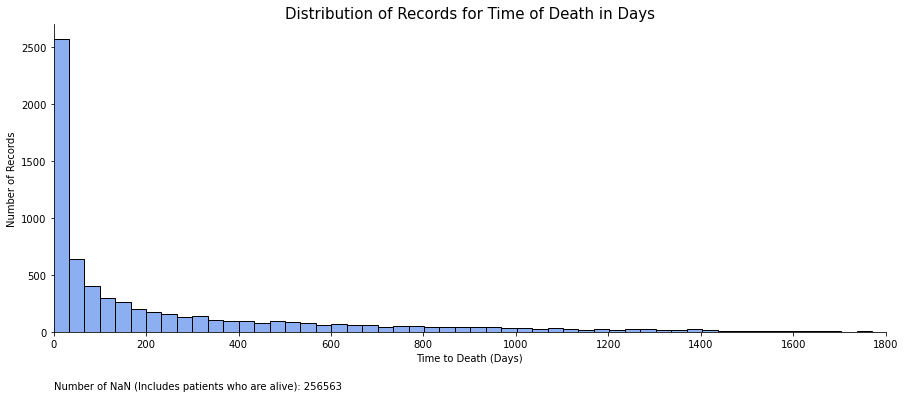

In [19]:
timetodeath_nans = (merged_df["TIMETODEATH"]/np.timedelta64(1, 'D')).isna().sum()

timetodeath = pd.DataFrame((merged_df["TIMETODEATH"]/np.timedelta64(1, 'D')).unique())
timetodeath = timetodeath.rename(columns = {0:'time'})

sns.displot(x='time', data=timetodeath.dropna(), aspect = 2.5, color = 'cornflowerblue')
plt.title('Distribution of Records for Time of Death in Days', size = 15)
plt.xlabel('Time to Death (Days)')
plt.ylabel('Number of Records')
plt.xlim(0,1800)
plt.text(0, -500, "Number of NaN (Includes patients who are alive): " + str(timetodeath_nans))
plt.show()

### Admission type

In [20]:
pd.DataFrame(merged_df['ADMISSION_TYPE'].value_counts(dropna=False)).rename(columns = {'ADMISSION_TYPE':'Count of Admission Types'})

,Count of Admission Types
EMERGENCY,335455
ELECTIVE,44445
URGENT,3513


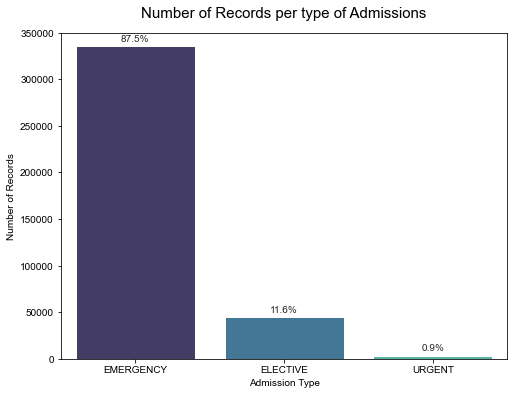

In [21]:
fig, ax = plt.subplots(figsize=(8,6))

sns.set_style("whitegrid")
sns.countplot(x = "ADMISSION_TYPE", data = merged_df, palette = "mako", ax = ax)
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width()/2
        y = p.get_height()
        ax.annotate(percentage, (x, y), xytext = (0,5), textcoords = "offset points", ha = 'center', size = 10)
plt.title('Number of Records per type of Admissions', size = 15, pad = 15)
plt.xlabel('Admission Type')
plt.ylabel('Number of Records')
ax.set_ylim(0,350000)
plt.show()

### Age

In [22]:
merged_df['AGE'] = merged_df['ADMITTIME'].dt.year - merged_df['DOB'].dt.year

Patients who are older than 89 years old at any time in the database have had their date of birth shifted to obscure their age and comply with HIPAA. The shift process was as follows: the patient’s age at their first admission was determined. The date of birth was then set to exactly 300 years before their first admission. The median age for the patients whose date of birth was shifted is 91.4.

In [23]:
merged_df.loc[merged_df['AGE'] > 100, 'AGE'] = 91.4

In [24]:
round(pd.DataFrame(merged_df["AGE"].describe()).rename(columns = {'AGE': 'Descriptive Statistic of Age'}))

,Descriptive Statistic of Age
count,383413.0
mean,64.0
std,18.0
min,15.0
25%,53.0
50%,65.0
75%,78.0
max,91.0


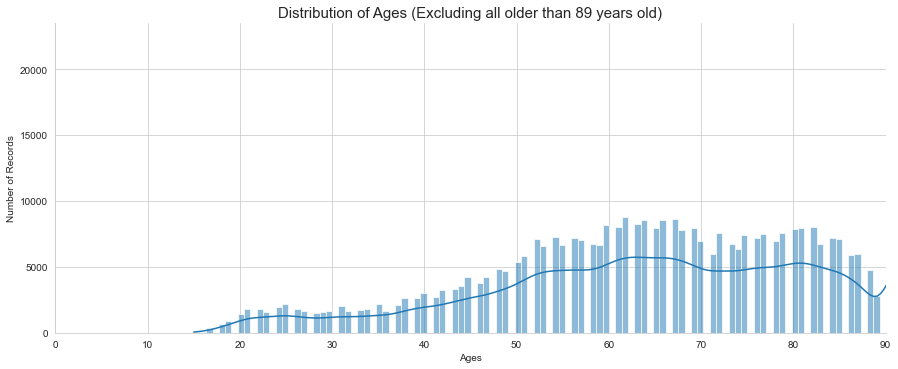

In [25]:
sns.displot(x = "AGE", data = merged_df, kde = True, aspect = 2.5)
plt.title('Distribution of Ages (Excluding all older than 89 years old)', size = 15)
plt.xlabel('Ages')
plt.ylabel('Number of Records')
plt.xlim(0,90)
plt.show()

### Ethnicity

In [26]:
merged_df['ETHNICITY'].replace(regex=r'^ASIAN\D*', value='ASIAN', inplace=True)
merged_df['ETHNICITY'].replace(regex=r'^WHITE\D*', value='WHITE', inplace=True)
merged_df['ETHNICITY'].replace(regex=r'^HISPANIC\D*', value='HISPANIC/LATINO', inplace=True)
merged_df['ETHNICITY'].replace(regex=r'^BLACK\D*', value='BLACK/AFRICAN AMERICAN', inplace=True)
merged_df['ETHNICITY'].replace(['UNABLE TO OBTAIN', 'OTHER', 'PATIENT DECLINED TO ANSWER', 
                         'UNKNOWN/NOT SPECIFIED'], value='OTHER/UNKNOWN', inplace=True)
merged_df['ETHNICITY'].loc[~merged_df['ETHNICITY'].isin(merged_df['ETHNICITY'].value_counts().nlargest(5).index.tolist())] = 'OTHER/UNKNOWN'
pd.DataFrame(merged_df['ETHNICITY'].value_counts()).rename(columns = {'ETHNICITY': 'Descriptive Statistics of Ethnicity'})

C:\Users\jaspe\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Descriptive Statistics of Ethnicity
WHITE,276146
BLACK/AFRICAN AMERICAN,42826
OTHER/UNKNOWN,38187
HISPANIC/LATINO,15976
ASIAN,10278


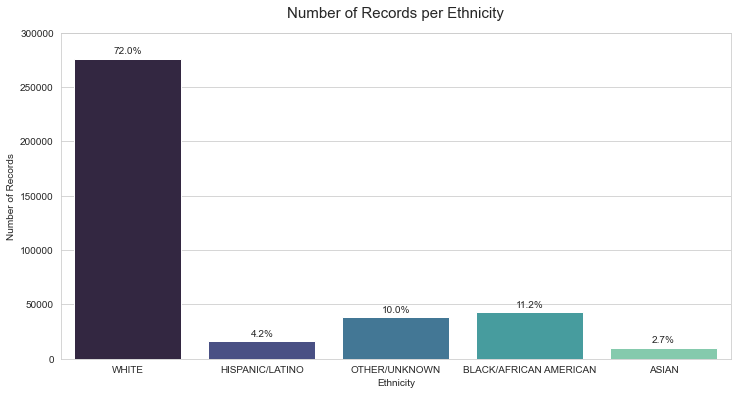

In [27]:
fig, ax = plt.subplots(figsize=(12,6))

sns.set_style("whitegrid")
sns.countplot(x = "ETHNICITY", data = merged_df, palette = "mako", ax = ax)
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width()/2
        y = p.get_height()
        ax.annotate(percentage, (x, y), xytext = (0,5), textcoords = "offset points", ha = 'center', size = 10)
plt.title('Number of Records per Ethnicity', size = 15, pad = 15)
plt.xlabel('Ethnicity')
plt.ylabel('Number of Records')
ax.set_ylim(0,300000)
plt.show()

### Gender

In [28]:
# Transform to binary
merged_df['GENDER'] = np.where(merged_df['GENDER']=='M', 1, 0)
merged_df = merged_df.rename(columns={'GENDER': 'MALE'})
pd.DataFrame(merged_df['MALE'].value_counts(dropna=False)).rename(columns = {'MALE':'Counts of Males'})

,Counts of Males
1,214976
0,168437


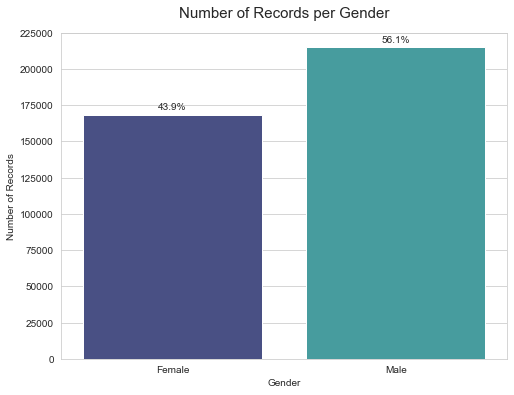

In [29]:
fig, ax = plt.subplots(figsize=(8,6))

sns.set_style("whitegrid")
fig = sns.countplot(x = "MALE", data = merged_df, palette = "mako", ax = ax)
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width()/2
        y = p.get_height()
        ax.annotate(percentage, (x, y), xytext = (0,5), textcoords = "offset points", ha = 'center', size = 10)
fig.set(xticklabels = ['Female', 'Male'])
ax.set_ylim(0,225000)
plt.title('Number of Records per Gender', size = 15, pad = 15)
plt.xlabel('Gender')
plt.ylabel('Number of Records')
plt.show()

### Insurance

In [30]:
pd.DataFrame(merged_df['INSURANCE'].value_counts(dropna=False)).rename(columns = {'INSURANCE': 'Counts of Insurance Type'})

,Counts of Insurance Type
Medicare,212469
Private,113969
Medicaid,40547
Government,12546
Self Pay,3882


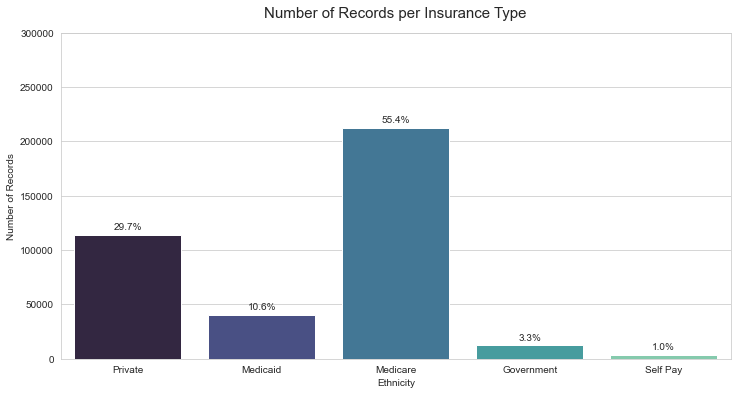

In [31]:
fig, ax = plt.subplots(figsize=(12,6))

sns.set_style("whitegrid")
sns.countplot(x = "INSURANCE", data = merged_df, palette = "mako", ax = ax)
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width()/2
        y = p.get_height()
        ax.annotate(percentage, (x, y), xytext = (0,5), textcoords = "offset points", ha = 'center', size = 10)
plt.title('Number of Records per Insurance Type', size = 15, pad = 15)
plt.xlabel('Ethnicity')
plt.ylabel('Number of Records')
ax.set_ylim(0,300000)
plt.show()

### Language

In [32]:
#Top 5 languages
pd.DataFrame(merged_df['LANGUAGE'].value_counts(dropna=False)).head().rename(columns = {'LANGUAGE': 'Count of patients per Language'})

,Count of patients per Language
ENGL,345989
SPAN,9178
RUSS,6385
PTUN,4024
CANT,3133


### Marital status

In [33]:
merged_df['MARITAL_STATUS'] = merged_df['MARITAL_STATUS'].fillna('UNKNOWN (DEFAULT)')
pd.DataFrame(merged_df['MARITAL_STATUS'].value_counts(dropna=False)).rename(columns = {'MARITAL_STATUS': 'Count per Marital Status'})

,Count per Marital Status
MARRIED,172147
SINGLE,113670
WIDOWED,51142
DIVORCED,24598
UNKNOWN (DEFAULT),17514
SEPARATED,4079
LIFE PARTNER,263


### Religion

In [34]:
merged_df['RELIGION'].loc[~merged_df['RELIGION'].isin(['NOT SPECIFIED', 'UNOBTAINABLE'])] = 'RELIGIOUS'
pd.DataFrame(merged_df['RELIGION'].value_counts(dropna=False)).rename(columns = {'RELIGION': 'Counts of Religious/Not'})

C:\Users\jaspe\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Counts of Religious/Not
RELIGIOUS,248450
NOT SPECIFIED,103589
UNOBTAINABLE,31374


### Past medical history

In [35]:
# Current smoker, diabetes, hypertension, and cerebrovascular disease, were associated with increased risk of mortality.
# https://www.medrxiv.org/content/10.1101/2020.08.31.20184952v1

merged_df['SMOKE'] = np.where((merged_df['225059_VALUE'] == 'Smoker'), 1, 0)
merged_df['DIABETES'] = np.where((merged_df['225059_VALUE'] == 'Diabetes - Insulin') | (merged_df['225059_VALUE'] == 'Diabetes - Oral Agent'), 1, 0)
merged_df['HYPERTENSION'] = np.where((merged_df['225811_VALUE'] == 'Hypertension'), 1, 0)

# Drop columns not needed
merged_df = merged_df.drop(['225059_VALUE', '225811_VALUE'], axis=1)

In [36]:
print("Number of Smokers: " + str(merged_df['SMOKE'].sum()))
print("Number of Diabetics: " + str(merged_df['DIABETES'].sum()))
print("Number of Patients with Hypertension: " + str(merged_df['HYPERTENSION'].sum()))

Number of Smokers: 11339
Number of Diabetics: 59875
Number of Patients with Hypertension: 95824


### Chart events

In [37]:
# Drop 220210_MEAN (respiratory rate) as same information, more complete, available in 224690_MEAN
merged_df = merged_df.drop(['220210_MEAN'], axis=1)

In [38]:
# Convert Celsius to Fahrenheit
merged_df['223762_MEAN'] = merged_df['223762_MEAN'].apply(lambda a: (a*(9/5))+32 if pd.notnull(a) else a)
merged_df.loc[merged_df['223761_MEAN'].isnull(),'223761_MEAN'] = merged_df['223762_MEAN']
merged_df = merged_df.drop(['223762_MEAN'], axis=1)

In [39]:
# Forward, backward, mean imputation
merged_df = merged_df.groupby(['HADM_ID','SUBJECT_ID','ICUSTAY_ID'], as_index=False).apply(lambda group: group.ffill())
merged_df = merged_df.groupby(['HADM_ID','SUBJECT_ID','ICUSTAY_ID'], as_index=False).apply(lambda group: group.bfill())
merged_df.loc[:, merged_df.columns.str.contains('_MEAN')] = merged_df.loc[:, merged_df.columns.str.contains('_MEAN')].apply(lambda x: x.fillna(x.mean())) 

In [40]:
# Missing values
((merged_df.loc[:, merged_df.columns.str.contains('_MEAN')].isnull() | merged_df.loc[:, merged_df.columns.str.contains('_MEAN')].isna()).sum() * 100 / merged_df.loc[:, merged_df.columns.str.contains('_MEAN')].index.size).round(2)

220045_MEAN    0.0
220181_MEAN    0.0
220227_MEAN    0.0
220228_MEAN    0.0
220277_MEAN    0.0
220546_MEAN    0.0
220603_MEAN    0.0
220615_MEAN    0.0
220635_MEAN    0.0
223761_MEAN    0.0
224690_MEAN    0.0
224749_MEAN    0.0
224828_MEAN    0.0
225667_MEAN    0.0
225668_MEAN    0.0
225677_MEAN    0.0
225690_MEAN    0.0
226534_MEAN    0.0
226536_MEAN    0.0
226537_MEAN    0.0
226540_MEAN    0.0
227073_MEAN    0.0
dtype: float64

### Prescriptions

In [41]:
merged_df['DRUG'] = merged_df['DRUG'].fillna(0)
round(pd.DataFrame(merged_df['DRUG'].describe()).rename(columns = {'DRUG':'Descriptive Statistics of Number of Drugs'}))

,Descriptive Statistics of Number of Drugs
count,383413.0
mean,1.0
std,7.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,220.0


### Diagnosis

In [42]:
#Top 10 diagnosis
pd.DataFrame(merged_df['DIAGNOSIS'].value_counts(dropna=False)).rename(columns = {'DIAGNOSIS': 'Counts of Types of Diagnosis'}).head(10)

,Counts of Types of Diagnosis
PNEUMONIA,19058
SEPSIS,11607
INTRACRANIAL HEMORRHAGE,9516
ALTERED MENTAL STATUS,9474
CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS GRAFT /SDA,8782
UPPER GI BLEED,8492
CONGESTIVE HEART FAILURE,6856
DIABETIC KETOACIDOSIS,5464
LOWER GI BLEED,5453
STROKE;TELEMETRY;TRANSIENT ISCHEMIC ATTACK,5257


### Services

In [43]:
merged_df['SERVICES'].replace(regex=r'^SURG\D*', value='Surgery', inplace=True)
merged_df['SERVICES'] = np.where(merged_df['SERVICES']=='Surgery', 1, 0)
merged_df = merged_df.rename(columns={'SERVICES': 'SURGERY'})
pd.DataFrame(merged_df['SURGERY'].value_counts(dropna=False)).rename(columns = {'SURGERY':'Counts of whether patient had surgery'})

,Counts of whether patient had surgery
0,363574
1,19839


## Naive Classifier

We are dealing with an imbalanced data-set where only 10% of the observations are "DEATH_IN_HOSPITAL". Hence it does not really make sense to benchmark the model against the Accuracy score. The benchmark would score 90% Accuracy just by predicting no deaths at all - which would be an accurate but also useless prediction.

In order to choose a more appropriate naive benchmark we should remember ourselves of what we are trying to accomplish: Identifying patients having high mortality risk. Hence we are more interested in identifying as many instances of high mortality risk as possible (= high Recall score). We are of course also not interested in just assigning high mortality risk to too many patients, so we also need to aim for a high Precision score. To balance off Recall and Precision scores we can finally look at the F1 score.

Below we have calculated Naive Benchmarks by applying a stratified strategy, using the prior probability of picking a patient with high mortality risk:

In [44]:
def naive_classifier(train_in, train_out, val_in, val_out):
    accuracy_score_list = []
    recall_score_list = []
    precision_score_list = []

    train_for_dummy = train_in.drop('INSURANCE', axis = 1)
    train_for_dummy = train_for_dummy.drop('ETHNICITY', axis = 1)

    trials = 101
    for k in range(1, trials):

        dummy_classifier = DummyClassifier(strategy="stratified")
        dummy_classifier.fit(train_for_dummy, train_out)

        # Calculate accuracy of naive classifier on validation set
        y_hat = dummy_classifier.predict(val_in)
        
        valid_accuracy_score = accuracy_score(val_out, y_hat)
        valid_recall_score = recall_score(val_out, y_hat)
        valid_precision_score = precision_score(val_out, y_hat)

        accuracy_score_list.append(valid_accuracy_score)
        recall_score_list.append(valid_recall_score)
        precision_score_list.append(valid_precision_score)


    average_accuracy_score = round(sum(accuracy_score_list)/(trials-1), 3)
    average_recall_score = round(sum(recall_score_list)/(trials-1), 3)
    average_precision_score = round(sum(precision_score_list)/(trials-1), 3)
    average_F1_score = round((2 * average_precision_score * average_recall_score) / (average_precision_score + average_recall_score),3)
    
    return(average_accuracy_score, average_recall_score, average_precision_score, average_F1_score)

In [45]:
def scores(the_pipe, val_in, val_out):
    proba_of_1 = the_pipe.predict_proba(val_in)[:, 1]
    predicted = the_pipe.predict(val_in)
    
    #ROC and AUC
    roc_auc_score = round(metrics.roc_auc_score(val_out, proba_of_1),3)
    fpr, tpr, threshold = metrics.roc_curve(val_out, proba_of_1)
    
    #Precision and Recall
    prec, recall, _ = metrics.precision_recall_curve(val_out, proba_of_1)
    avg_precision_score = round(metrics.average_precision_score(val_out, proba_of_1),3)

    #Confusion Matrix
    cm = metrics.confusion_matrix(val_out, predicted)
    
    return(roc_auc_score, fpr, tpr, prec, recall, avg_precision_score, cm)

## Regression (by hour)

In [46]:
merged_df['TIMESINCEADMISSION'] = np.floor(merged_df['TIMESINCEADMISSION'].dt.total_seconds() / 3600)

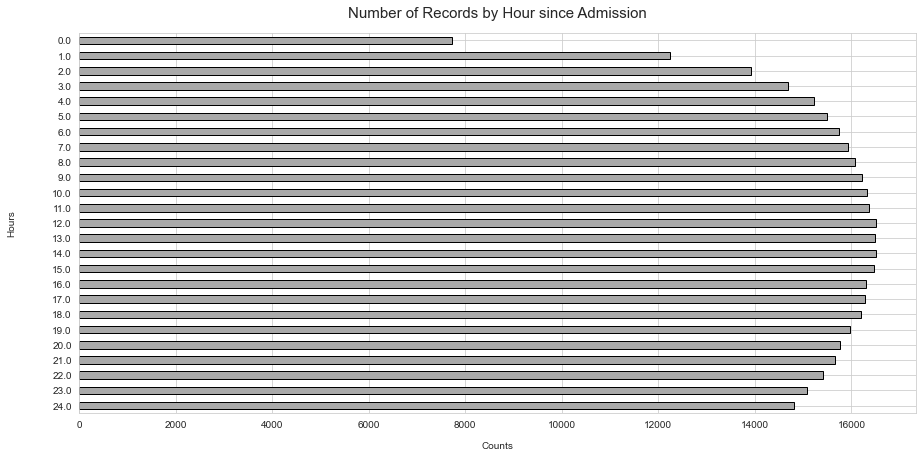

In [48]:
# Nr of records by hour since admission
fig, ax = plt.subplots(figsize = (15,7))

merged_df['TIMESINCEADMISSION'].value_counts(sort=False, \
                                             dropna=False).sort_index(ascending=False).plot.barh(color = 'darkgrey', \
                                                                                                 width = 0.5, \
                                                                                                 edgecolor = 'black')
plt.title("Number of Records by Hour since Admission", size = 15, pad = 15)
ax.set_xlabel('Counts')
ax.xaxis.set_label_coords(0.5, -0.075)

ax.set_ylabel('Hours')
ax.yaxis.set_label_coords(-0.075, 0.5)

plt.show()

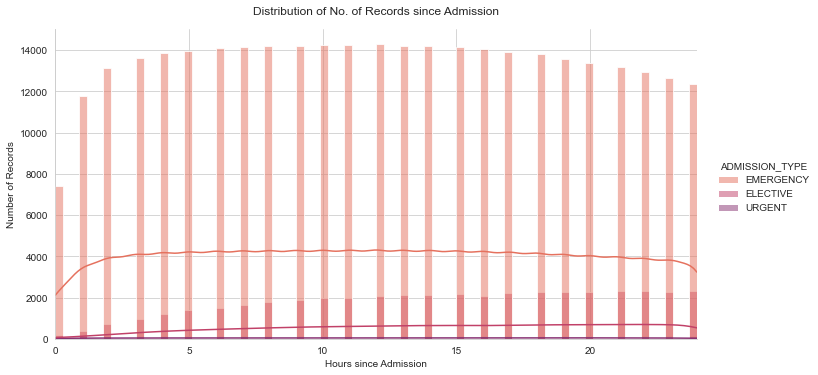

In [49]:
ax = sns.displot(data=merged_df, x="TIMESINCEADMISSION", hue = "ADMISSION_TYPE", palette="flare", kde = True, aspect = 2)

ax.set(xlabel='Hours since Admission', ylabel='Number of Records')
plt.xlim(0, 24)

plt.title("Distribution of No. of Records since Admission", pad = 15)
plt.show()

In [50]:
# Determine the intermediate measurement(1: within first 6 hrs), early measurement (2: within first 6 - 24 hours, 
# and later measurement (3: after the first 24 hours))
immediate_df = merged_df[merged_df['TIMESINCEADMISSION'] == 6.0]
early_df = merged_df[merged_df['TIMESINCEADMISSION'] == 12.0]
later_df = merged_df[merged_df['TIMESINCEADMISSION'] == 24.0]

## Train & test (T+6)

In [51]:
# Select dataset
test_df = immediate_df

In [52]:
# Select variables
test_df = test_df[['MALE','AGE','INSURANCE','ETHNICITY','SMOKE','DIABETES','HYPERTENSION','SURGERY','DRUG'
                    ,'220045_MEAN'
                    ,'220181_MEAN'
                    ,'220227_MEAN'
                    ,'220228_MEAN'
                    ,'220277_MEAN'
                    ,'220546_MEAN'
                    ,'220603_MEAN'
                    ,'220615_MEAN'
                    ,'220635_MEAN'
                    ,'223761_MEAN'
                    ,'224690_MEAN'
                    ,'224749_MEAN'
                    ,'224828_MEAN'
                    ,'225667_MEAN'
                    ,'225668_MEAN'
                    ,'225677_MEAN'
                    ,'225690_MEAN'
                    ,'226534_MEAN'
                    ,'226536_MEAN'
                    ,'226537_MEAN'
                    ,'226540_MEAN'
                    ,'227073_MEAN'
                    ,'DEATH_IN_HOSPITAL']]

### Descriptive Statistics

In [53]:
# Descriptive statistics
test_df.describe().T.iloc[3:]

,count,mean,std,min,25%,50%,75%,max
DIABETES,15734.0,0.154506,0.361445,0.00,0.000000,0.000000,0.000000,1.00
HYPERTENSION,15734.0,0.248634,0.432235,0.00,0.000000,0.000000,0.000000,1.00
SURGERY,15734.0,0.044363,0.205906,0.00,0.000000,0.000000,0.000000,1.00
DRUG,15734.0,0.958180,5.502018,0.00,0.000000,0.000000,0.000000,140.00
220045_MEAN,15734.0,84.695290,18.649772,0.00,71.000000,83.000000,97.000000,174.50
220181_MEAN,15734.0,76.058197,15.039555,0.00,66.000000,76.000000,84.000000,203.00
220227_MEAN,15734.0,95.848738,2.367232,0.00,95.860047,95.860047,95.860047,100.00
220228_MEAN,15734.0,10.955471,2.029817,0.00,9.500000,10.922720,12.300000,20.30
220277_MEAN,15734.0,97.873651,77.377932,9.00,96.000000,98.000000,100.000000,9795.00
220546_MEAN,15734.0,11.447079,9.626384,0.10,7.300000,10.200000,13.600000,471.70


In [54]:
# Shuffle and split data into training set & validation set
train, validation = train_test_split(test_df, train_size = 0.5, random_state=123, shuffle=True)

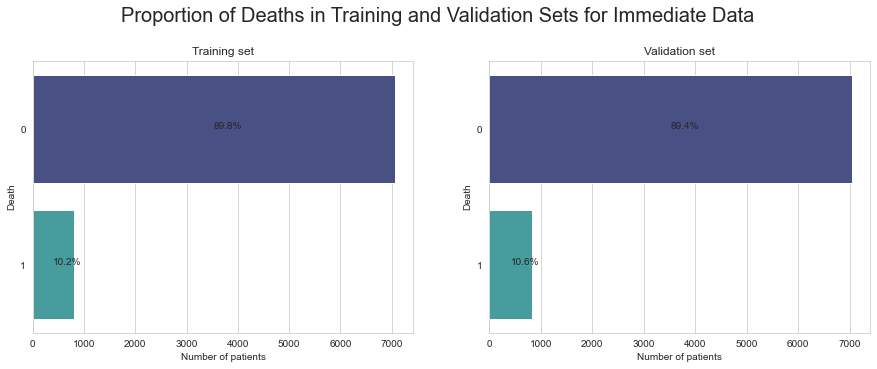

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))

for i, dataset in enumerate([train, validation]):
    ax = axes[i]
    sns.countplot(y="DEATH_IN_HOSPITAL", data=dataset, order=[0,1], ax = ax, palette = "mako")
    ax.set_xlabel('Number of patients')
    ax.set_ylabel('Death')
    total = len(dataset['DEATH_IN_HOSPITAL'])
    for p in ax.patches:
            percentage = '{:.1f}%'.format(100 * p.get_width()/total)
            x = p.get_x() + p.get_width()/2
            y = p.get_y() + p.get_height()/2
            ax.annotate(percentage, (x, y))
            if i == 0:
                ax.set_title('Training set')
            else:
                ax.set_title('Validation set')
                
fig.suptitle("Proportion of Deaths in Training and Validation Sets for Immediate Data", size = 20, y = 1.03)

plt.show()

In [56]:
train_in = train.drop('DEATH_IN_HOSPITAL',axis=1)
train_out = train['DEATH_IN_HOSPITAL']
validation_in = validation.drop('DEATH_IN_HOSPITAL',axis=1)
validation_out = validation['DEATH_IN_HOSPITAL']

### Naive Classifier

In [57]:
naive = naive_classifier(train_in, train_out, validation_in, validation_out)

display(Markdown(f'**Benchmark Accuracy Score:** ${naive[0]}$'))
display(Markdown(f'**Benchmark Recall Score:** ${naive[1]}$'))
display(Markdown(f'**Benchmark Precision Score:** ${naive[2]}$'))
display(Markdown(f'**Benchmark F1 Score:** ${naive[3]}$'))

**Benchmark Accuracy Score:** $0.814$

**Benchmark Recall Score:** $0.101$

**Benchmark Precision Score:** $0.104$

**Benchmark F1 Score:** $0.102$

### Logistic Regression

In [58]:
class Columns(BaseEstimator, TransformerMixin):
    def __init__(self, names=None):
        self.names = names

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X):
        return X[self.names]

numeric = ['AGE','MALE','SMOKE','DIABETES','HYPERTENSION','SURGERY','DRUG'
            ,'220045_MEAN'
            ,'220181_MEAN'
            ,'220227_MEAN'
            ,'220228_MEAN'
            ,'220277_MEAN'
            ,'220546_MEAN'
            ,'220603_MEAN'
            ,'220615_MEAN'
            ,'220635_MEAN'
            ,'223761_MEAN'
            ,'224690_MEAN'
            ,'224749_MEAN'
            ,'224828_MEAN'
            ,'225667_MEAN'
            ,'225668_MEAN'
            ,'225677_MEAN'
            ,'225690_MEAN'
            ,'226534_MEAN'
            ,'226536_MEAN'
            ,'226537_MEAN'
            ,'226540_MEAN'
            ,'227073_MEAN']

categorical = ['INSURANCE','ETHNICITY']

pipe = Pipeline([
    ("features", FeatureUnion([
        ('numeric', make_pipeline(Columns(names=numeric),StandardScaler())),
        ('categorical', make_pipeline(Columns(names=categorical),OneHotEncoder(sparse=False)))
    ])),
    ('sampling', SMOTE(random_state=123)),
    ('model', LogisticRegression(max_iter=10000))
])

In [59]:
pipe.fit(train_in, train_out)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('numeric',
                                                 Pipeline(steps=[('columns',
                                                                  Columns(names=['AGE',
                                                                                 'MALE',
                                                                                 'SMOKE',
                                                                                 'DIABETES',
                                                                                 'HYPERTENSION',
                                                                                 'SURGERY',
                                                                                 'DRUG',
                                                                                 '220045_MEAN',
                                                                                 '220181_MEAN',
    

In [60]:
ct = ColumnTransformer([("onehotencoder", OneHotEncoder(handle_unknown="ignore"), ['INSURANCE','ETHNICITY'])], remainder="passthrough")

ct = ct.fit(train_in)
    
feature_names = ct.get_feature_names()

In [61]:
importances = pipe.named_steps['model'].coef_.flatten()

best_features = pd.DataFrame(columns=['Feature', 'Coeff'])

for f in range(len(feature_names)):
    best_features = best_features.append({'Feature': feature_names[f], 'Coeff': importances[f]}, ignore_index=True)

best_features = best_features.iloc[(-np.abs(best_features['Coeff'].values)).argsort()]

best_features.head(20)

,Feature,Coeff
0,onehotencoder__x0_Government,0.786503
35,226536_MEAN,-0.592831
37,226540_MEAN,0.571493
28,224749_MEAN,0.487566
29,224828_MEAN,-0.357866
20,220228_MEAN,-0.357335
7,onehotencoder__x1_HISPANIC/LATINO,0.342985
24,220615_MEAN,0.301263
16,DRUG,-0.264671
31,225668_MEAN,0.257729


In [62]:
X, y = SMOTE(random_state=123).fit_resample(pipe.named_steps['features'].fit_transform(train_in), train_out)

logit_model=sm.Logit(y,X)

result=logit_model.fit(maxiter=10000)

#print(result.summary2(xname=numeric + (pipe.named_steps['features'].transformer_list[1][1].named_steps['onehotencoder'].get_feature_names().tolist())))
print(result.summary2(xname=feature_names))

Optimization terminated successfully.
         Current function value: 0.546170
         Iterations 10
                                     Results: Logit
Model:                       Logit                    Pseudo R-squared:        0.212     
Dependent Variable:          DEATH_IN_HOSPITAL        AIC:                     15517.3219
Date:                        2021-01-02 19:08         BIC:                     15804.4682
No. Observations:            14136                    Log-Likelihood:          -7720.7   
Df Model:                    37                       LL-Null:                 -9798.3   
Df Residuals:                14098                    LLR p-value:             0.0000    
Converged:                   1.0000                   Scale:                   1.0000    
No. Iterations:              10.0000                                                     
-----------------------------------------------------------------------------------------
                                   

C:\Users\jaspe\Anaconda3\lib\site-packages\statsmodels\base\model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\Users\jaspe\AppData\Roaming\Python\Python37\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\jaspe\AppData\Roaming\Python\Python37\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\jaspe\AppData\Roaming\Python\Python37\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [63]:
result.summary2(xname=feature_names).tables[1]

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
onehotencoder__x0_Government,0.786924,0.031919,24.653823,3.348574e-134,0.724364,0.849484
onehotencoder__x0_Medicaid,0.100539,0.020992,4.789400,1.672809e-06,0.059395,0.141682
onehotencoder__x0_Medicare,0.039389,0.020945,1.880546,6.003367e-02,-0.001663,0.080441
onehotencoder__x0_Private,-0.105154,0.021244,-4.949820,7.428223e-07,-0.146791,-0.063516
onehotencoder__x0_Self Pay,-0.124493,0.020957,-5.940501,2.841527e-09,-0.165567,-0.083419
onehotencoder__x1_ASIAN,-0.113883,0.020591,-5.530733,3.188946e-08,-0.154240,-0.073525
onehotencoder__x1_BLACK/AFRICAN AMERICAN,0.225097,0.022339,10.076183,7.040823e-24,0.181312,0.268881
onehotencoder__x1_HISPANIC/LATINO,0.343257,0.022091,15.537998,1.918843e-54,0.299959,0.386556
onehotencoder__x1_OTHER/UNKNOWN,0.010025,0.022138,0.452854,6.506537e-01,-0.033364,0.053415
onehotencoder__x1_WHITE,-0.011899,0.020062,-0.593106,5.531103e-01,-0.051220,0.027422


### Random Forest Model

In [64]:
pipe_random_forest = Pipeline([
    ("features", FeatureUnion([
        ('numeric', make_pipeline(Columns(names=numeric),StandardScaler())),
        ('categorical', make_pipeline(Columns(names=categorical),OneHotEncoder(sparse=False)))
    ])),
    ('sampling', SMOTE(random_state=123)),
    ('model', RandomForestClassifier(n_estimators = 100))
])

pipe_random_forest.fit(train_in, train_out)
print(classification_report(validation_out, pipe_random_forest.predict(validation_in)))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      7037
           1       0.49      0.27      0.34       830

    accuracy                           0.89      7867
   macro avg       0.70      0.62      0.64      7867
weighted avg       0.87      0.89      0.88      7867



### Adaboost Model

In [65]:
pipe_adaboost = Pipeline([
    ("features", FeatureUnion([
        ('numeric', make_pipeline(Columns(names=numeric),StandardScaler())),
        ('categorical', make_pipeline(Columns(names=categorical),OneHotEncoder(sparse=False)))
    ])),
    ('sampling', SMOTE(random_state=123)),
    ('model', AdaBoostClassifier(n_estimators = 100))
])

pipe_adaboost.fit(train_in, train_out)
print(classification_report(validation_out, pipe_adaboost.predict(validation_in)))

              precision    recall  f1-score   support

           0       0.93      0.92      0.92      7037
           1       0.37      0.42      0.40       830

    accuracy                           0.86      7867
   macro avg       0.65      0.67      0.66      7867
weighted avg       0.87      0.86      0.87      7867



### Gradient Boost Model

In [66]:
pipe_gradient_boost = Pipeline([
    ("features", FeatureUnion([
        ('numeric', make_pipeline(Columns(names=numeric),StandardScaler())),
        ('categorical', make_pipeline(Columns(names=categorical),OneHotEncoder(sparse=False)))
    ])),
    ('sampling', SMOTE(random_state=123)),
    ('model', GradientBoostingClassifier(n_estimators = 100))
])

pipe_gradient_boost.fit(train_in, train_out)
print(classification_report(validation_out, pipe_gradient_boost.predict(validation_in)))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      7037
           1       0.45      0.35      0.39       830

    accuracy                           0.89      7867
   macro avg       0.69      0.65      0.67      7867
weighted avg       0.88      0.89      0.88      7867



### Scores

In [67]:
# Scores for Immediate

logistic_scores = scores(pipe, validation_in, validation_out)
random_forest_scores = scores(pipe_random_forest, validation_in, validation_out)
adaboost_scores = scores(pipe_adaboost, validation_in, validation_out)
gradient_boost_scores = scores(pipe_gradient_boost, validation_in, validation_out)

classifiers_immediate = {"Logistic Regression": logistic_scores, \
               "Random Forest Model": random_forest_scores, \
               "Adaboost Model": adaboost_scores, \
               "Gradient Boost Model": gradient_boost_scores}

pipes = {"Logistic Regression": pipe, \
         "Random Forest Model": pipe_random_forest, \
         "Adaboost Model": pipe_adaboost, \
         "Gradient Boost Model": pipe_gradient_boost}

### Precision-Recall Curve and ROC-AUC Curve

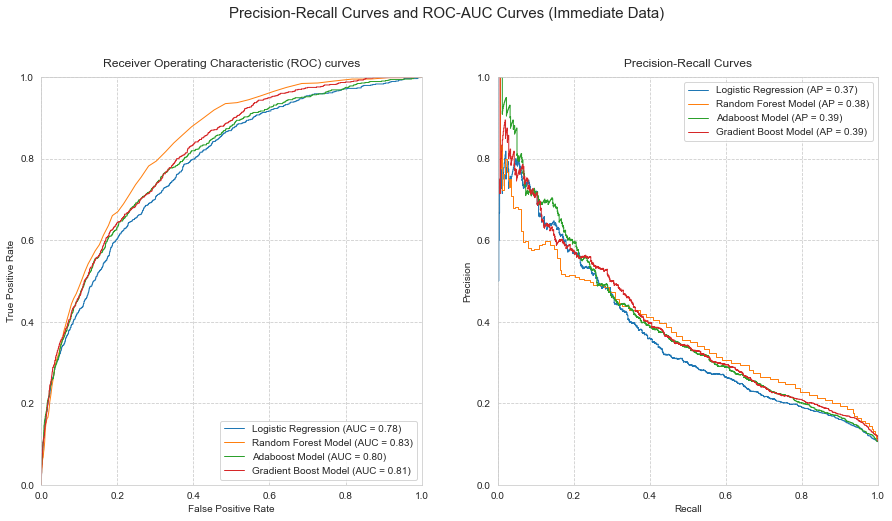

In [68]:
# prepare plots
fig, [ax_roc, ax_pre_recall] = plt.subplots(1, 2, figsize=(15, 7.5))
fig.suptitle('Precision-Recall Curves and ROC-AUC Curves (Immediate Data)', size = 15, y = 1.01)

for name, clf in pipes.items():
    metrics.plot_roc_curve(clf, validation_in, validation_out, ax=ax_roc, name=name, linewidth = 1)
    metrics.plot_precision_recall_curve(clf, validation_in, validation_out, ax=ax_pre_recall, name=name, linewidth = 1)

ax_roc.set_title('Receiver Operating Characteristic (ROC) curves', pad = 10)
ax_pre_recall.set_title('Precision-Recall Curves', pad = 10)

ax_roc.grid(linestyle='--')
ax_pre_recall.grid(linestyle='--')

ax_roc.set_xlim(0,1)
ax_roc.set_ylim(0,1)
ax_pre_recall.set_xlim(0,1)
ax_pre_recall.set_ylim(0,1)

plt.legend()
plt.show()

### Confusion Matrix

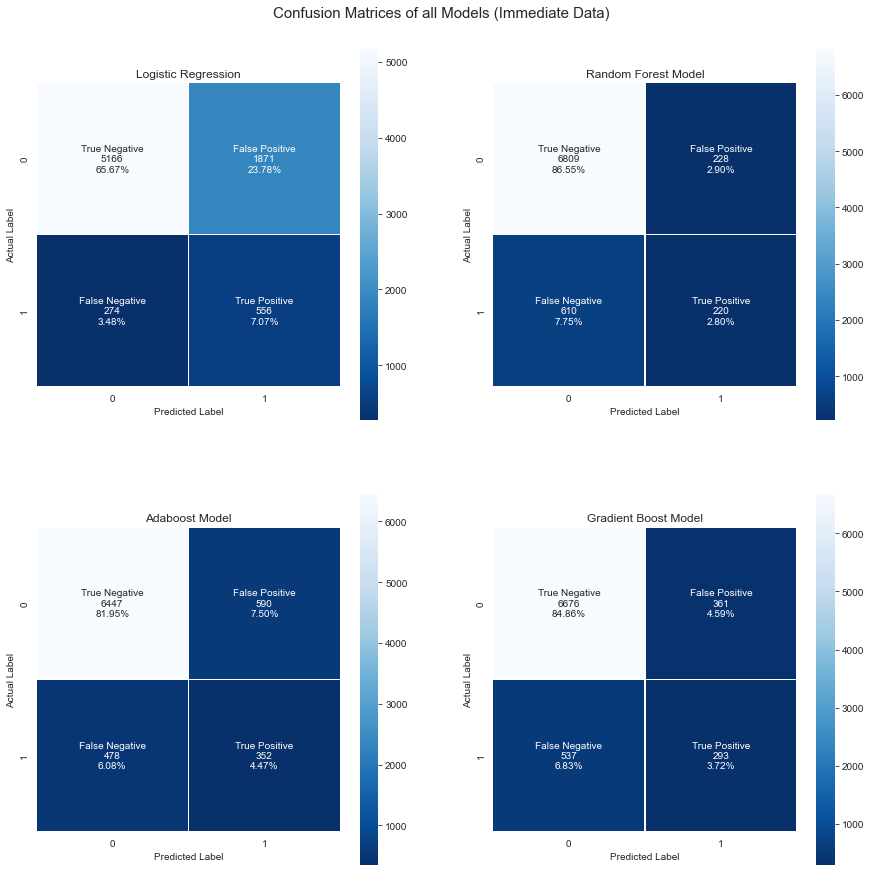

In [69]:
fig, axs = plt.subplots(2, 2, figsize = (15,15))
fig.suptitle('Confusion Matrices of all Models (Immediate Data)', size = 15, y = 0.92)

confusion_matrix = [logistic_scores[6], random_forest_scores[6], adaboost_scores[6], gradient_boost_scores[6]]
label = []

for i in confusion_matrix:
    group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    group_counts = ["{0:0.0f}".format(value) for value in
                    i.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         i.flatten()/np.sum(i)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    label.append(labels)

sns.heatmap(logistic_scores[6], annot=label[0], fmt="", linewidths=.5, square = True, cmap = 'Blues_r', ax=axs[0, 0])
axs[0, 0].set_title("Logistic Regression")
axs[0, 0].set_xlabel("Predicted Label")
axs[0, 0].set_ylabel("Actual Label")

sns.heatmap(random_forest_scores[6], annot=label[1], fmt="", linewidths=.5, square = True, cmap = 'Blues_r', ax = axs[0, 1])
axs[0, 1].set_title("Random Forest Model")
axs[0, 1].set_xlabel("Predicted Label")
axs[0, 1].set_ylabel("Actual Label")

sns.heatmap(adaboost_scores[6], annot=label[2], fmt="", linewidths=.5, square = True, cmap = 'Blues_r', ax = axs[1, 0])
axs[1, 0].set_title("Adaboost Model")
axs[1, 0].set_xlabel("Predicted Label")
axs[1, 0].set_ylabel("Actual Label")

sns.heatmap(gradient_boost_scores[6], annot=label[3], fmt="", linewidths=.5, square = True, cmap = 'Blues_r', ax = axs[1, 1])
axs[1, 1].set_title("Gradient Boost Model")
axs[1, 1].set_xlabel("Predicted Label")
axs[1, 1].set_ylabel("Actual Label")

plt.show()

### Comparison of Metrics

In [70]:
precision_log,recall_log,fscore_log,support_log = metrics.precision_recall_fscore_support(validation_out, \
                                                                                          pipe.predict(validation_in))

precision_random,recall_random,fscore_random,support_random = metrics.precision_recall_fscore_support(validation_out, \
                                                                                          pipe_random_forest.predict(validation_in))

precision_adaboost,recall_adaboost,fscore_adaboost,support_adaboost = metrics.precision_recall_fscore_support(validation_out, \
                                                                                          pipe_adaboost.predict(validation_in))

precision_gradient,recall_gradient,fscore_gradient,support_gradient = metrics.precision_recall_fscore_support(validation_out, \
                                                                                          pipe_gradient_boost.predict(validation_in))

comparison = {'Metrics': ['Precision', 'Recall', 'F1 Score', 'Accuracy', 'AUC Score', 'Average Precision Score'], \
              'Naive Classifier': [naive[2], naive[1], naive[3], naive[0], "-", "-"], \
              'Logistic Regression': [round(precision_log[1], 3), \
                                     round(recall_log[1], 3), \
                                     round(fscore_log[1], 3), \
                                     round(metrics.accuracy_score(validation_out, pipe.predict(validation_in)), 3), \
                                     logistic_scores[0], \
                                     logistic_scores[5]],
              'Random Forest Model': [round(precision_random[1], 3), \
                                     round(recall_random[1], 3), \
                                     round(fscore_random[1], 3), \
                                     round(metrics.accuracy_score(validation_out, pipe_random_forest.predict(validation_in)), 3), \
                                     random_forest_scores[0], \
                                     random_forest_scores[5]],
              'Adaboost Model': [round(precision_adaboost[1], 3), \
                                 round(recall_adaboost[1], 3), \
                                 round(fscore_adaboost[1], 3), \
                                 round(metrics.accuracy_score(validation_out, pipe_adaboost.predict(validation_in)), 3), \
                                 adaboost_scores[0], \
                                 adaboost_scores[5]],
              'Gradient Boost Model': [round(precision_gradient[1], 3), \
                                       round(recall_gradient[1], 3), \
                                       round(fscore_gradient[1], 3), \
                                       round(metrics.accuracy_score(validation_out, pipe_gradient_boost.predict(validation_in)), 3), \
                                       gradient_boost_scores[0], \
                                       gradient_boost_scores[5]]}
pd.DataFrame(comparison, columns = ['Metrics', 'Naive Classifier', 'Logistic Regression', \
                                    'Random Forest Model', 'Adaboost Model', 'Gradient Boost Model'])

,Metrics,Naive Classifier,Logistic Regression,Random Forest Model,Adaboost Model,Gradient Boost Model
0,Precision,0.104,0.229,0.491,0.374,0.448
1,Recall,0.101,0.670,0.265,0.424,0.353
2,F1 Score,0.102,0.341,0.344,0.397,0.395
3,Accuracy,0.814,0.727,0.893,0.864,0.886
4,AUC Score,-,0.783,0.830,0.798,0.808
5,Average Precision Score,-,0.367,0.381,0.394,0.392


## Train & test (T+12)

In [71]:
# Select dataset
test_df = early_df

In [72]:
# Select variables
test_df = test_df[['MALE','AGE','INSURANCE','ETHNICITY','SMOKE','DIABETES','HYPERTENSION','SURGERY','DRUG'
                    ,'220045_MEAN'
                    ,'220181_MEAN'
                    ,'220227_MEAN'
                    ,'220228_MEAN'
                    ,'220277_MEAN'
                    ,'220546_MEAN'
                    ,'220603_MEAN'
                    ,'220615_MEAN'
                    ,'220635_MEAN'
                    ,'223761_MEAN'
                    ,'224690_MEAN'
                    ,'224749_MEAN'
                    ,'224828_MEAN'
                    ,'225667_MEAN'
                    ,'225668_MEAN'
                    ,'225677_MEAN'
                    ,'225690_MEAN'
                    ,'226534_MEAN'
                    ,'226536_MEAN'
                    ,'226537_MEAN'
                    ,'226540_MEAN'
                    ,'227073_MEAN'
                    ,'DEATH_IN_HOSPITAL']]

### Descriptive Statistics

In [73]:
# Descriptive statistics
test_df.describe().T.iloc[3:]

,count,mean,std,min,25%,50%,75%,max
DIABETES,16511.0,0.156199,0.363055,0.00,0.000000,0.000000,0.000000,1.000000
HYPERTENSION,16511.0,0.251590,0.433940,0.00,0.000000,0.000000,1.000000,1.000000
SURGERY,16511.0,0.052632,0.223304,0.00,0.000000,0.000000,0.000000,1.000000
DRUG,16511.0,1.162740,6.125053,0.00,0.000000,0.000000,0.000000,220.000000
220045_MEAN,16511.0,84.235265,18.186060,29.00,71.000000,83.000000,96.000000,194.777778
220181_MEAN,16511.0,83.356828,912.309768,0.00,66.000000,76.000000,83.000000,117120.030000
220227_MEAN,16511.0,95.867999,2.135700,0.00,95.860047,95.860047,95.860047,120.000000
220228_MEAN,16511.0,10.948609,1.962384,0.00,9.600000,10.900000,12.200000,20.300000
220277_MEAN,16511.0,97.054133,3.125700,0.00,96.000000,97.983333,99.000000,100.000000
220546_MEAN,16511.0,11.338983,9.328403,0.10,7.250000,10.100000,13.500000,471.700000


In [74]:
# Shuffle and split data into training set & validation set
train, validation = train_test_split(test_df, train_size = 0.5, random_state=123, shuffle=True)

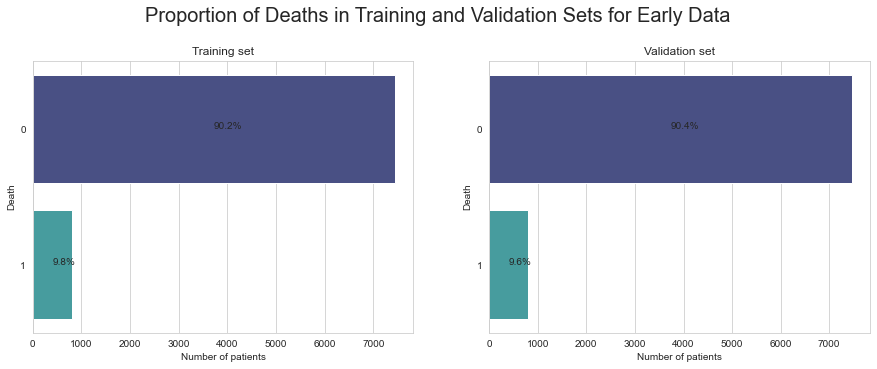

In [77]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))

for i, dataset in enumerate([train, validation]):
    ax = axes[i]
    sns.countplot(y="DEATH_IN_HOSPITAL", data=dataset, order=[0,1], ax = ax, palette = "mako")
    ax.set_xlabel('Number of patients')
    ax.set_ylabel('Death')
    total = len(dataset['DEATH_IN_HOSPITAL'])
    for p in ax.patches:
            percentage = '{:.1f}%'.format(100 * p.get_width()/total)
            x = p.get_x() + p.get_width()/2
            y = p.get_y() + p.get_height()/2
            ax.annotate(percentage, (x, y))
            if i == 0:
                ax.set_title('Training set')
            else:
                ax.set_title('Validation set')
                
fig.suptitle("Proportion of Deaths in Training and Validation Sets for Early Data", size = 20, y = 1.03)

plt.show()

In [78]:
train_in = train.drop('DEATH_IN_HOSPITAL',axis=1)
train_out = train['DEATH_IN_HOSPITAL']
validation_in = validation.drop('DEATH_IN_HOSPITAL',axis=1)
validation_out = validation['DEATH_IN_HOSPITAL']

### Naive Classifier

In [79]:
naive = naive_classifier(train_in, train_out, validation_in, validation_out)

display(Markdown(f'**Benchmark Accuracy Score:** ${naive[0]}$'))
display(Markdown(f'**Benchmark Recall Score:** ${naive[1]}$'))
display(Markdown(f'**Benchmark Precision Score:** ${naive[2]}$'))
display(Markdown(f'**Benchmark F1 Score:** ${naive[3]}$'))

**Benchmark Accuracy Score:** $0.825$

**Benchmark Recall Score:** $0.099$

**Benchmark Precision Score:** $0.096$

**Benchmark F1 Score:** $0.097$

### Logistic Regression

In [80]:
class Columns(BaseEstimator, TransformerMixin):
    def __init__(self, names=None):
        self.names = names

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X):
        return X[self.names]

numeric = ['AGE','MALE','SMOKE','DIABETES','HYPERTENSION','SURGERY','DRUG'
            ,'220045_MEAN'
            ,'220181_MEAN'
            ,'220227_MEAN'
            ,'220228_MEAN'
            ,'220277_MEAN'
            ,'220546_MEAN'
            ,'220603_MEAN'
            ,'220615_MEAN'
            ,'220635_MEAN'
            ,'223761_MEAN'
            ,'224690_MEAN'
            ,'224749_MEAN'
            ,'224828_MEAN'
            ,'225667_MEAN'
            ,'225668_MEAN'
            ,'225677_MEAN'
            ,'225690_MEAN'
            ,'226534_MEAN'
            ,'226536_MEAN'
            ,'226537_MEAN'
            ,'226540_MEAN'
            ,'227073_MEAN']

categorical = ['INSURANCE','ETHNICITY']

pipe = Pipeline([
    ("features", FeatureUnion([
        ('numeric', make_pipeline(Columns(names=numeric),StandardScaler())),
        ('categorical', make_pipeline(Columns(names=categorical),OneHotEncoder(sparse=False)))
    ])),
    ('sampling', SMOTE(random_state=123)),
    ('model', LogisticRegression(max_iter=10000))
])

In [81]:
pipe.fit(train_in, train_out)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('numeric',
                                                 Pipeline(steps=[('columns',
                                                                  Columns(names=['AGE',
                                                                                 'MALE',
                                                                                 'SMOKE',
                                                                                 'DIABETES',
                                                                                 'HYPERTENSION',
                                                                                 'SURGERY',
                                                                                 'DRUG',
                                                                                 '220045_MEAN',
                                                                                 '220181_MEAN',
    

In [82]:
ct = ColumnTransformer([("onehotencoder", OneHotEncoder(handle_unknown="ignore"), ['INSURANCE','ETHNICITY'])], remainder="passthrough")

ct = ct.fit(train_in)
    
feature_names = ct.get_feature_names()

In [83]:
importances = pipe.named_steps['model'].coef_.flatten()

best_features = pd.DataFrame(columns=['Feature', 'Coeff'])

for f in range(len(feature_names)):
    best_features = best_features.append({'Feature': feature_names[f], 'Coeff': importances[f]}, ignore_index=True)

best_features = best_features.iloc[(-np.abs(best_features['Coeff'].values)).argsort()]

best_features.head(20)

,Feature,Coeff
35,226536_MEAN,-0.698691
0,onehotencoder__x0_Government,0.687497
37,226540_MEAN,0.489522
29,224828_MEAN,-0.484405
28,224749_MEAN,0.472357
20,220228_MEAN,-0.421905
34,226534_MEAN,0.409101
33,225690_MEAN,0.357764
24,220615_MEAN,0.317657
5,onehotencoder__x1_ASIAN,-0.260323


In [84]:
X, y = SMOTE(random_state=123).fit_resample(pipe.named_steps['features'].fit_transform(train_in), train_out)

logit_model=sm.Logit(y,X)

result=logit_model.fit(maxiter=10000)

#print(result.summary2(xname=numeric + (pipe.named_steps['features'].transformer_list[1][1].named_steps['onehotencoder'].get_feature_names().tolist())))
print(result.summary2(xname=feature_names))

Optimization terminated successfully.
         Current function value: 0.553729
         Iterations 2117
                                             Results: Logit
Model:                            Logit                         Pseudo R-squared:             0.201     
Dependent Variable:               DEATH_IN_HOSPITAL             AIC:                          16568.2768
Date:                             2021-01-02 19:09              BIC:                          16857.4028
No. Observations:                 14892                         Log-Likelihood:               -8246.1   
Df Model:                         37                            LL-Null:                      -10322.   
Df Residuals:                     14854                         LLR p-value:                  0.0000    
Converged:                        1.0000                        Scale:                        1.0000    
No. Iterations:                   2117.0000                                                         

In [85]:
result.summary2(xname=feature_names).tables[1]

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
onehotencoder__x0_Government,0.687957,2.911037e-02,2.363270e+01,1.778220e-123,6.309013e-01,7.450119e-01
onehotencoder__x0_Medicaid,0.078375,2.046883e-02,3.828989e+00,1.286708e-04,3.825675e-02,1.184931e-01
onehotencoder__x0_Medicare,-0.026061,2.079119e-02,-1.253456e+00,2.100398e-01,-6.681083e-02,1.468915e-02
onehotencoder__x0_Private,-0.110727,2.061531e-02,-5.371108e+00,7.825444e-08,-1.511323e-01,-7.032177e-02
onehotencoder__x0_Self Pay,-0.127694,2.047589e-02,-6.236316e+00,4.479970e-10,-1.678261e-01,-8.756210e-02
onehotencoder__x1_ASIAN,-0.260598,2.351080e-02,-1.108418e+01,1.497139e-28,-3.066783e-01,-2.145176e-01
onehotencoder__x1_BLACK/AFRICAN AMERICAN,0.236317,2.102788e-02,1.123829e+01,2.644635e-29,1.951035e-01,2.775312e-01
onehotencoder__x1_HISPANIC/LATINO,0.211167,2.084807e-02,1.012886e+01,4.114135e-24,1.703058e-01,2.520287e-01
onehotencoder__x1_OTHER/UNKNOWN,-0.124751,2.151114e-02,-5.799351e+00,6.657196e-09,-1.669117e-01,-8.258961e-02
onehotencoder__x1_WHITE,-0.025192,1.754208e-02,-1.436108e+00,1.509716e-01,-5.957417e-02,9.189522e-03


### Random Forest Model

In [86]:
pipe_random_forest = Pipeline([
    ("features", FeatureUnion([
        ('numeric', make_pipeline(Columns(names=numeric),StandardScaler())),
        ('categorical', make_pipeline(Columns(names=categorical),OneHotEncoder(sparse=False)))
    ])),
    ('sampling', SMOTE(random_state=123)),
    ('model', RandomForestClassifier(n_estimators = 100))
])

pipe_random_forest.fit(train_in, train_out)
print(classification_report(validation_out, pipe_random_forest.predict(validation_in)))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      7465
           1       0.48      0.28      0.36       791

    accuracy                           0.90      8256
   macro avg       0.71      0.63      0.65      8256
weighted avg       0.88      0.90      0.89      8256



### Adaboost Model

In [87]:
pipe_adaboost = Pipeline([
    ("features", FeatureUnion([
        ('numeric', make_pipeline(Columns(names=numeric),StandardScaler())),
        ('categorical', make_pipeline(Columns(names=categorical),OneHotEncoder(sparse=False)))
    ])),
    ('sampling', SMOTE(random_state=123)),
    ('model', AdaBoostClassifier(n_estimators = 100))
])

pipe_adaboost.fit(train_in, train_out)
print(classification_report(validation_out, pipe_adaboost.predict(validation_in)))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      7465
           1       0.36      0.43      0.39       791

    accuracy                           0.87      8256
   macro avg       0.65      0.67      0.66      8256
weighted avg       0.88      0.87      0.88      8256



### Gradient Boost Model

In [88]:
pipe_gradient_boost = Pipeline([
    ("features", FeatureUnion([
        ('numeric', make_pipeline(Columns(names=numeric),StandardScaler())),
        ('categorical', make_pipeline(Columns(names=categorical),OneHotEncoder(sparse=False)))
    ])),
    ('sampling', SMOTE(random_state=123)),
    ('model', GradientBoostingClassifier(n_estimators = 100))
])

pipe_gradient_boost.fit(train_in, train_out)
print(classification_report(validation_out, pipe_gradient_boost.predict(validation_in)))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      7465
           1       0.42      0.36      0.39       791

    accuracy                           0.89      8256
   macro avg       0.67      0.65      0.66      8256
weighted avg       0.88      0.89      0.89      8256



### Scores

In [89]:
# Scores for Early

logistic_scores = scores(pipe, validation_in, validation_out)
random_forest_scores = scores(pipe_random_forest, validation_in, validation_out)
adaboost_scores = scores(pipe_adaboost, validation_in, validation_out)
gradient_boost_scores = scores(pipe_gradient_boost, validation_in, validation_out)

classifiers_early = {"Logistic Regression": logistic_scores, \
               "Random Forest Model": random_forest_scores, \
               "Adaboost Model": adaboost_scores, \
               "Gradient Boost Model": gradient_boost_scores}

pipes = {"Logistic Regression": pipe, \
         "Random Forest Model": pipe_random_forest, \
         "Adaboost Model": pipe_adaboost, \
         "Gradient Boost Model": pipe_gradient_boost}

### Precision-Recall Curve and ROC-AUC Curve

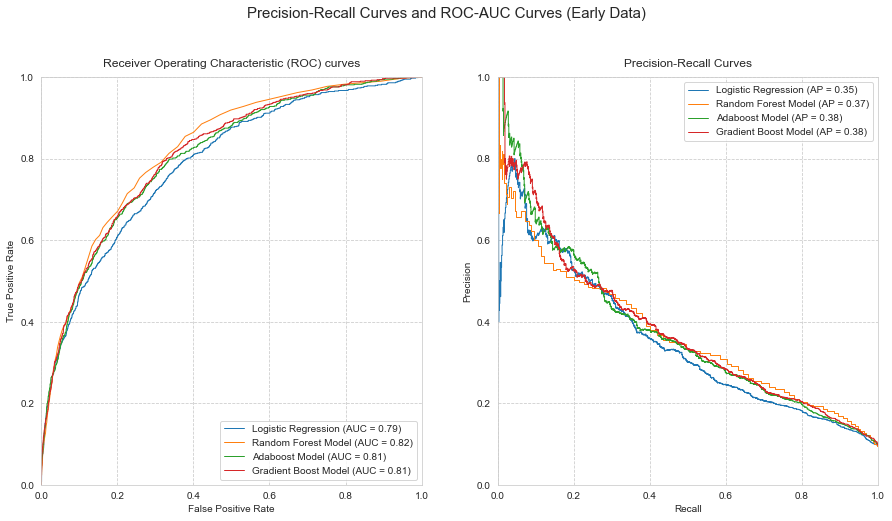

In [90]:
# prepare plots
fig, [ax_roc, ax_pre_recall] = plt.subplots(1, 2, figsize=(15, 7.5))
fig.suptitle('Precision-Recall Curves and ROC-AUC Curves (Early Data)', size = 15, y = 1.01)

for name, clf in pipes.items():
    metrics.plot_roc_curve(clf, validation_in, validation_out, ax=ax_roc, name=name, linewidth = 1)
    metrics.plot_precision_recall_curve(clf, validation_in, validation_out, ax=ax_pre_recall, name=name, linewidth = 1)

ax_roc.set_title('Receiver Operating Characteristic (ROC) curves', pad = 10)
ax_pre_recall.set_title('Precision-Recall Curves', pad = 10)

ax_roc.grid(linestyle='--')
ax_pre_recall.grid(linestyle='--')

ax_roc.set_xlim(0,1)
ax_roc.set_ylim(0,1)
ax_pre_recall.set_xlim(0,1)
ax_pre_recall.set_ylim(0,1)

plt.legend()
plt.show()

### Confusion Matrix

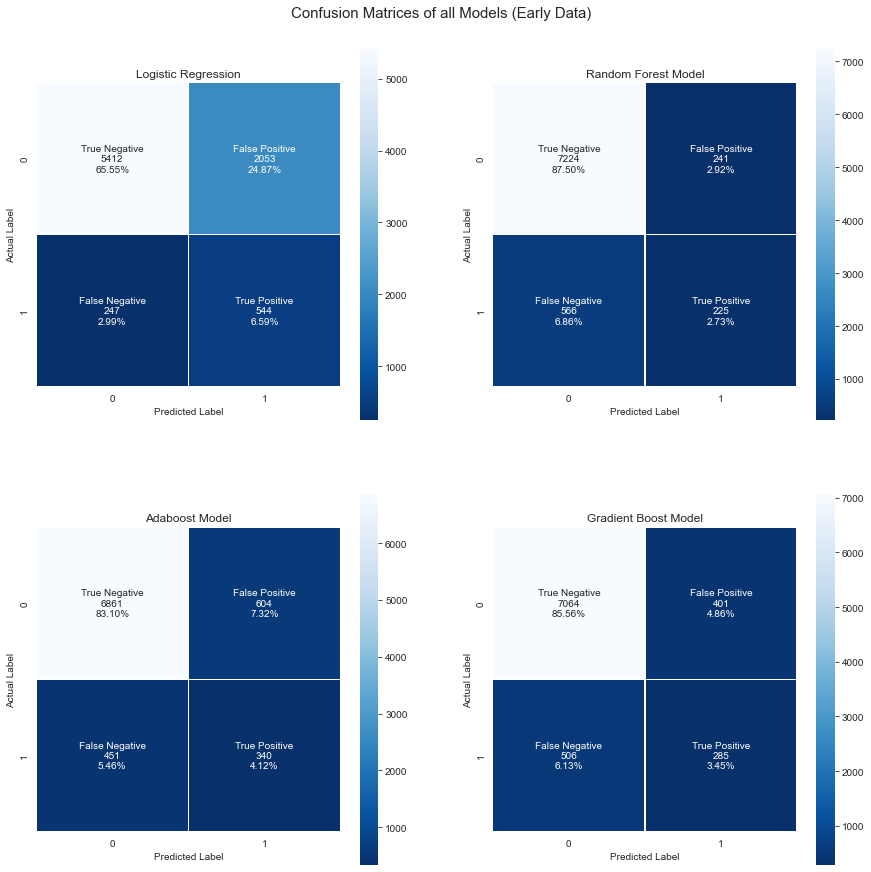

In [91]:
fig, axs = plt.subplots(2, 2, figsize = (15,15))
fig.suptitle('Confusion Matrices of all Models (Early Data)', size = 15, y = 0.92)

confusion_matrix = [logistic_scores[6], random_forest_scores[6], adaboost_scores[6], gradient_boost_scores[6]]
label = []

for i in confusion_matrix:
    group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    group_counts = ["{0:0.0f}".format(value) for value in
                    i.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         i.flatten()/np.sum(i)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    label.append(labels)

sns.heatmap(logistic_scores[6], annot=label[0], fmt="", linewidths=.5, square = True, cmap = 'Blues_r', ax=axs[0, 0])
axs[0, 0].set_title("Logistic Regression")
axs[0, 0].set_xlabel("Predicted Label")
axs[0, 0].set_ylabel("Actual Label")

sns.heatmap(random_forest_scores[6], annot=label[1], fmt="", linewidths=.5, square = True, cmap = 'Blues_r', ax = axs[0, 1])
axs[0, 1].set_title("Random Forest Model")
axs[0, 1].set_xlabel("Predicted Label")
axs[0, 1].set_ylabel("Actual Label")

sns.heatmap(adaboost_scores[6], annot=label[2], fmt="", linewidths=.5, square = True, cmap = 'Blues_r', ax = axs[1, 0])
axs[1, 0].set_title("Adaboost Model")
axs[1, 0].set_xlabel("Predicted Label")
axs[1, 0].set_ylabel("Actual Label")

sns.heatmap(gradient_boost_scores[6], annot=label[3], fmt="", linewidths=.5, square = True, cmap = 'Blues_r', ax = axs[1, 1])
axs[1, 1].set_title("Gradient Boost Model")
axs[1, 1].set_xlabel("Predicted Label")
axs[1, 1].set_ylabel("Actual Label")

plt.show()

### Comparison of Metrics

In [92]:
precision_log,recall_log,fscore_log,support_log = metrics.precision_recall_fscore_support(validation_out, \
                                                                                          pipe.predict(validation_in))

precision_random,recall_random,fscore_random,support_random = metrics.precision_recall_fscore_support(validation_out, \
                                                                                          pipe_random_forest.predict(validation_in))

precision_adaboost,recall_adaboost,fscore_adaboost,support_adaboost = metrics.precision_recall_fscore_support(validation_out, \
                                                                                          pipe_adaboost.predict(validation_in))

precision_gradient,recall_gradient,fscore_gradient,support_gradient = metrics.precision_recall_fscore_support(validation_out, \
                                                                                          pipe_gradient_boost.predict(validation_in))

comparison = {'Metrics': ['Precision', 'Recall', 'F1 Score', 'Accuracy', 'AUC Score', 'Average Precision Score'], \
              'Naive Classifier': [naive[2], naive[1], naive[3], naive[0], "-", "-"], \
              'Logistic Regression': [round(precision_log[1], 3), \
                                     round(recall_log[1], 3), \
                                     round(fscore_log[1], 3), \
                                     round(metrics.accuracy_score(validation_out, pipe.predict(validation_in)), 3), \
                                     logistic_scores[0], \
                                     logistic_scores[5]],
              'Random Forest Model': [round(precision_random[1], 3), \
                                     round(recall_random[1], 3), \
                                     round(fscore_random[1], 3), \
                                     round(metrics.accuracy_score(validation_out, pipe_random_forest.predict(validation_in)), 3), \
                                     random_forest_scores[0], \
                                     random_forest_scores[5]],
              'Adaboost Model': [round(precision_adaboost[1], 3), \
                                 round(recall_adaboost[1], 3), \
                                 round(fscore_adaboost[1], 3), \
                                 round(metrics.accuracy_score(validation_out, pipe_adaboost.predict(validation_in)), 3), \
                                 adaboost_scores[0], \
                                 adaboost_scores[5]],
              'Gradient Boost Model': [round(precision_gradient[1], 3), \
                                       round(recall_gradient[1], 3), \
                                       round(fscore_gradient[1], 3), \
                                       round(metrics.accuracy_score(validation_out, pipe_gradient_boost.predict(validation_in)), 3), \
                                       gradient_boost_scores[0], \
                                       gradient_boost_scores[5]]}
pd.DataFrame(comparison, columns = ['Metrics', 'Naive Classifier', 'Logistic Regression', \
                                    'Random Forest Model', 'Adaboost Model', 'Gradient Boost Model'])

,Metrics,Naive Classifier,Logistic Regression,Random Forest Model,Adaboost Model,Gradient Boost Model
0,Precision,0.096,0.209,0.483,0.360,0.415
1,Recall,0.099,0.688,0.284,0.430,0.360
2,F1 Score,0.097,0.321,0.358,0.392,0.386
3,Accuracy,0.825,0.721,0.902,0.872,0.890
4,AUC Score,-,0.788,0.823,0.806,0.811
5,Average Precision Score,-,0.349,0.367,0.377,0.380


## Train & test (T+24)

In [93]:
# Select dataset
test_df = later_df

In [94]:
# Select variables
test_df = test_df[['MALE','AGE','INSURANCE','ETHNICITY','SMOKE','DIABETES','HYPERTENSION','SURGERY','DRUG'
                    ,'220045_MEAN'
                    ,'220181_MEAN'
                    ,'220227_MEAN'
                    ,'220228_MEAN'
                    ,'220277_MEAN'
                    ,'220546_MEAN'
                    ,'220603_MEAN'
                    ,'220615_MEAN'
                    ,'220635_MEAN'
                    ,'223761_MEAN'
                    ,'224690_MEAN'
                    ,'224749_MEAN'
                    ,'224828_MEAN'
                    ,'225667_MEAN'
                    ,'225668_MEAN'
                    ,'225677_MEAN'
                    ,'225690_MEAN'
                    ,'226534_MEAN'
                    ,'226536_MEAN'
                    ,'226537_MEAN'
                    ,'226540_MEAN'
                    ,'227073_MEAN'
                    ,'DEATH_IN_HOSPITAL']]

### Descriptive Statistics

In [95]:
# Descriptive statistics
test_df.describe().T.iloc[3:]

,count,mean,std,min,25%,50%,75%,max
DIABETES,14819.0,0.156691,0.363521,0.00,0.000000,0.000000,0.000000,1.0
HYPERTENSION,14819.0,0.249882,0.432959,0.00,0.000000,0.000000,0.000000,1.0
SURGERY,14819.0,0.060260,0.237977,0.00,0.000000,0.000000,0.000000,1.0
DRUG,14819.0,1.822660,8.697911,0.00,0.000000,0.000000,0.000000,148.0
220045_MEAN,14819.0,84.763603,17.603768,0.00,72.000000,83.000000,96.000000,166.0
220181_MEAN,14819.0,76.063971,14.500393,0.00,67.000000,77.000000,83.000000,203.0
220227_MEAN,14819.0,95.882169,2.015466,0.00,95.860047,95.860047,95.860047,100.0
220228_MEAN,14819.0,10.824270,1.849895,3.50,9.500000,10.800000,12.000000,19.8
220277_MEAN,14819.0,96.812210,3.181525,0.00,95.000000,97.000000,99.000000,100.0
220546_MEAN,14819.0,11.354085,8.038868,0.10,7.600000,10.400000,13.400000,462.6


In [96]:
# Shuffle and split data into training set & validation set
train, validation = train_test_split(test_df, train_size = 0.5, random_state=123, shuffle=True)

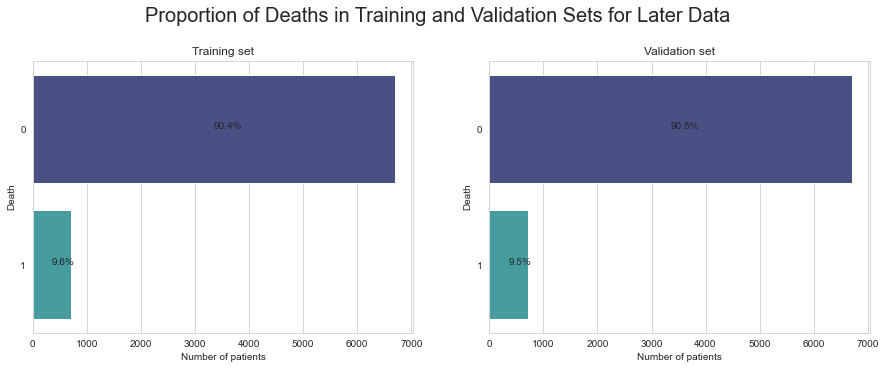

In [102]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))

for i, dataset in enumerate([train, validation]):
    ax = axes[i]
    sns.countplot(y="DEATH_IN_HOSPITAL", data=dataset, order=[0,1], ax = ax, palette = "mako")
    ax.set_xlabel('Number of patients')
    ax.set_ylabel('Death')
    total = len(dataset['DEATH_IN_HOSPITAL'])
    for p in ax.patches:
            percentage = '{:.1f}%'.format(100 * p.get_width()/total)
            x = p.get_x() + p.get_width()/2
            y = p.get_y() + p.get_height()/2
            ax.annotate(percentage, (x, y))
            if i == 0:
                ax.set_title('Training set')
            else:
                ax.set_title('Validation set')
                
fig.suptitle("Proportion of Deaths in Training and Validation Sets for Later Data", size = 20, y = 1.03)

plt.show()

In [98]:
train_in = train.drop('DEATH_IN_HOSPITAL',axis=1)
train_out = train['DEATH_IN_HOSPITAL']
validation_in = validation.drop('DEATH_IN_HOSPITAL',axis=1)
validation_out = validation['DEATH_IN_HOSPITAL']

### Naive Classifier

In [99]:
naive = naive_classifier(train_in, train_out, validation_in, validation_out)

display(Markdown(f'**Benchmark Accuracy Score:** ${naive[0]}$'))
display(Markdown(f'**Benchmark Recall Score:** ${naive[1]}$'))
display(Markdown(f'**Benchmark Precision Score:** ${naive[2]}$'))
display(Markdown(f'**Benchmark F1 Score:** ${naive[3]}$'))

**Benchmark Accuracy Score:** $0.828$

**Benchmark Recall Score:** $0.095$

**Benchmark Precision Score:** $0.095$

**Benchmark F1 Score:** $0.095$

### Logistic Regression

In [103]:
class Columns(BaseEstimator, TransformerMixin):
    def __init__(self, names=None):
        self.names = names

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X):
        return X[self.names]

numeric = ['AGE','MALE','SMOKE','DIABETES','HYPERTENSION','SURGERY','DRUG'
            ,'220045_MEAN'
            ,'220181_MEAN'
            ,'220227_MEAN'
            ,'220228_MEAN'
            ,'220277_MEAN'
            ,'220546_MEAN'
            ,'220603_MEAN'
            ,'220615_MEAN'
            ,'220635_MEAN'
            ,'223761_MEAN'
            ,'224690_MEAN'
            ,'224749_MEAN'
            ,'224828_MEAN'
            ,'225667_MEAN'
            ,'225668_MEAN'
            ,'225677_MEAN'
            ,'225690_MEAN'
            ,'226534_MEAN'
            ,'226536_MEAN'
            ,'226537_MEAN'
            ,'226540_MEAN'
            ,'227073_MEAN']

categorical = ['INSURANCE','ETHNICITY']

pipe = Pipeline([
    ("features", FeatureUnion([
        ('numeric', make_pipeline(Columns(names=numeric),StandardScaler())),
        ('categorical', make_pipeline(Columns(names=categorical),OneHotEncoder(sparse=False)))
    ])),
    ('sampling', SMOTE(random_state=123)),
    ('model', LogisticRegression(max_iter=10000))
])

In [104]:
pipe.fit(train_in, train_out)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('numeric',
                                                 Pipeline(steps=[('columns',
                                                                  Columns(names=['AGE',
                                                                                 'MALE',
                                                                                 'SMOKE',
                                                                                 'DIABETES',
                                                                                 'HYPERTENSION',
                                                                                 'SURGERY',
                                                                                 'DRUG',
                                                                                 '220045_MEAN',
                                                                                 '220181_MEAN',
    

In [105]:
ct = ColumnTransformer([("onehotencoder", OneHotEncoder(handle_unknown="ignore"), ['INSURANCE','ETHNICITY'])], remainder="passthrough")

ct = ct.fit(train_in)
    
feature_names = ct.get_feature_names()

In [106]:
importances = pipe.named_steps['model'].coef_.flatten()

best_features = pd.DataFrame(columns=['Feature', 'Coeff'])

for f in range(len(feature_names)):
    best_features = best_features.append({'Feature': feature_names[f], 'Coeff': importances[f]}, ignore_index=True)

best_features = best_features.iloc[(-np.abs(best_features['Coeff'].values)).argsort()]

best_features.head(20)

,Feature,Coeff
0,onehotencoder__x0_Government,0.693644
33,225690_MEAN,0.689721
35,226536_MEAN,-0.635945
37,226540_MEAN,0.601698
28,224749_MEAN,0.558858
7,onehotencoder__x1_HISPANIC/LATINO,0.348032
30,225667_MEAN,-0.308329
24,220615_MEAN,0.293592
20,220228_MEAN,-0.274589
29,224828_MEAN,-0.262075


In [107]:
X, y = SMOTE(random_state=123).fit_resample(pipe.named_steps['features'].fit_transform(train_in), train_out)

logit_model=sm.Logit(y,X)

result=logit_model.fit(maxiter=35)

#print(result.summary2(xname=numeric + (pipe.named_steps['features'].transformer_list[1][1].named_steps['onehotencoder'].get_feature_names().tolist())))
print(result.summary2(xname=feature_names))

         Current function value: inf
         Iterations: 35
                                                    Results: Logit
Model:                                  Logit                               Pseudo R-squared:                   -inf   
Dependent Variable:                     DEATH_IN_HOSPITAL                   AIC:                                inf    
Date:                                   2021-01-02 19:09                    BIC:                                inf    
No. Observations:                       13402                               Log-Likelihood:                     -inf   
Df Model:                               37                                  LL-Null:                            -9289.6
Df Residuals:                           13364                               LLR p-value:                        1.0000 
Converged:                              0.0000                              Scale:                              1.0000 
No. Iterations:                 

C:\Users\jaspe\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1789: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\jaspe\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [108]:
result.summary2(xname=feature_names).tables[1]

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
onehotencoder__x0_Government,6.769260e-01,3.179916e-02,21.287542,1.480947e-100,6.146008e-01,7.392513e-01
onehotencoder__x0_Medicaid,1.251190e-01,2.195088e-02,5.699954,1.198399e-08,8.209608e-02,1.681420e-01
onehotencoder__x0_Medicare,3.511824e-02,2.068686e-02,1.697611,8.958120e-02,-5.427259e-03,7.566375e-02
onehotencoder__x0_Private,-1.650496e-01,2.241662e-02,-7.362822,1.800621e-13,-2.089854e-01,-1.211138e-01
onehotencoder__x0_Self Pay,-1.291961e-01,2.179222e-02,-5.928542,3.056365e-09,-1.719080e-01,-8.648411e-02
onehotencoder__x1_ASIAN,-2.672839e-01,2.420871e-02,-11.040817,2.428142e-28,-3.147321e-01,-2.198357e-01
onehotencoder__x1_BLACK/AFRICAN AMERICAN,1.713874e-01,1.855847e-02,9.234999,2.582893e-20,1.350135e-01,2.077614e-01
onehotencoder__x1_HISPANIC/LATINO,3.551379e-01,2.222324e-02,15.980474,1.748110e-57,3.115812e-01,3.986947e-01
onehotencoder__x1_OTHER/UNKNOWN,-2.153792e-01,2.397411e-02,-8.983824,2.615171e-19,-2.623676e-01,-1.683908e-01
onehotencoder__x1_WHITE,2.050602e-02,2.132330e-02,0.961672,3.362143e-01,-2.128687e-02,6.229892e-02


### Random Forest Model

In [109]:
pipe_random_forest = Pipeline([
    ("features", FeatureUnion([
        ('numeric', make_pipeline(Columns(names=numeric),StandardScaler())),
        ('categorical', make_pipeline(Columns(names=categorical),OneHotEncoder(sparse=False)))
    ])),
    ('sampling', SMOTE(random_state=123)),
    ('model', RandomForestClassifier(n_estimators = 100))
])

pipe_random_forest.fit(train_in, train_out)
print(classification_report(validation_out, pipe_random_forest.predict(validation_in)))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      6703
           1       0.43      0.20      0.27       707

    accuracy                           0.90      7410
   macro avg       0.68      0.58      0.61      7410
weighted avg       0.87      0.90      0.88      7410



### Adaboost Model

In [110]:
pipe_adaboost = Pipeline([
    ("features", FeatureUnion([
        ('numeric', make_pipeline(Columns(names=numeric),StandardScaler())),
        ('categorical', make_pipeline(Columns(names=categorical),OneHotEncoder(sparse=False)))
    ])),
    ('sampling', SMOTE(random_state=123)),
    ('model', AdaBoostClassifier(n_estimators = 100))
])

pipe_adaboost.fit(train_in, train_out)
print(classification_report(validation_out, pipe_adaboost.predict(validation_in)))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      6703
           1       0.31      0.40      0.35       707

    accuracy                           0.86      7410
   macro avg       0.62      0.65      0.64      7410
weighted avg       0.88      0.86      0.87      7410



### Gradient Boost Model

In [111]:
pipe_gradient_boost = Pipeline([
    ("features", FeatureUnion([
        ('numeric', make_pipeline(Columns(names=numeric),StandardScaler())),
        ('categorical', make_pipeline(Columns(names=categorical),OneHotEncoder(sparse=False)))
    ])),
    ('sampling', SMOTE(random_state=123)),
    ('model', GradientBoostingClassifier(n_estimators = 100))
])

pipe_gradient_boost.fit(train_in, train_out)
print(classification_report(validation_out, pipe_gradient_boost.predict(validation_in)))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      6703
           1       0.33      0.31      0.32       707

    accuracy                           0.88      7410
   macro avg       0.63      0.62      0.63      7410
weighted avg       0.87      0.88      0.87      7410



### Scores

In [112]:
# Scores for Later

logistic_scores = scores(pipe, validation_in, validation_out)
random_forest_scores = scores(pipe_random_forest, validation_in, validation_out)
adaboost_scores = scores(pipe_adaboost, validation_in, validation_out)
gradient_boost_scores = scores(pipe_gradient_boost, validation_in, validation_out)

classifiers_later = {"Logistic Regression": logistic_scores, \
               "Random Forest Model": random_forest_scores, \
               "Adaboost Model": adaboost_scores, \
               "Gradient Boost Model": gradient_boost_scores}

pipes = {"Logistic Regression": pipe, \
         "Random Forest Model": pipe_random_forest, \
         "Adaboost Model": pipe_adaboost, \
         "Gradient Boost Model": pipe_gradient_boost}

### Precision-Recall Curve and ROC-AUC Curve

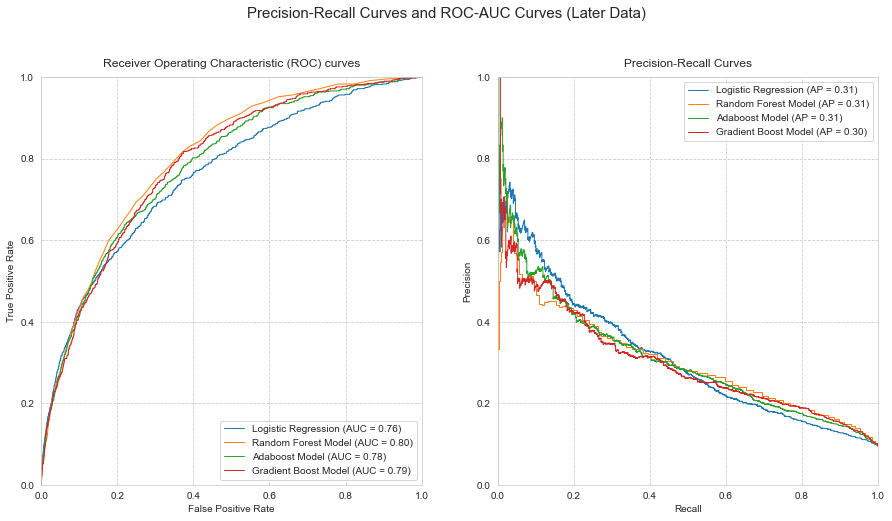

In [113]:
# prepare plots
fig, [ax_roc, ax_pre_recall] = plt.subplots(1, 2, figsize=(15, 7.5))
fig.suptitle('Precision-Recall Curves and ROC-AUC Curves (Later Data)', size = 15, y = 1.01)

for name, clf in pipes.items():
    metrics.plot_roc_curve(clf, validation_in, validation_out, ax=ax_roc, name=name, linewidth = 1)
    metrics.plot_precision_recall_curve(clf, validation_in, validation_out, ax=ax_pre_recall, name=name, linewidth = 1)

ax_roc.set_title('Receiver Operating Characteristic (ROC) curves', pad = 10)
ax_pre_recall.set_title('Precision-Recall Curves', pad = 10)

ax_roc.grid(linestyle='--')
ax_pre_recall.grid(linestyle='--')

ax_roc.set_xlim(0,1)
ax_roc.set_ylim(0,1)
ax_pre_recall.set_xlim(0,1)
ax_pre_recall.set_ylim(0,1)

plt.legend()
plt.show()

### Confusion Matrix

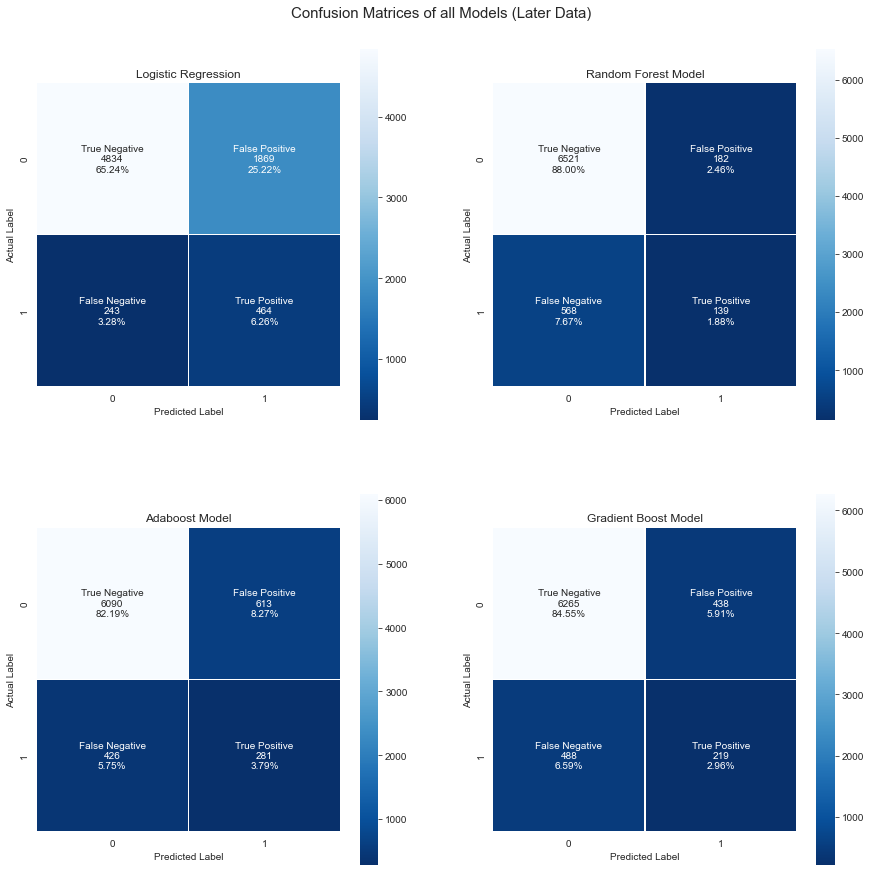

In [114]:
fig, axs = plt.subplots(2, 2, figsize = (15,15))
fig.suptitle('Confusion Matrices of all Models (Later Data)', size = 15, y = 0.92)

confusion_matrix = [logistic_scores[6], random_forest_scores[6], adaboost_scores[6], gradient_boost_scores[6]]
label = []

for i in confusion_matrix:
    group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    group_counts = ["{0:0.0f}".format(value) for value in
                    i.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         i.flatten()/np.sum(i)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    label.append(labels)

sns.heatmap(logistic_scores[6], annot=label[0], fmt="", linewidths=.5, square = True, cmap = 'Blues_r', ax=axs[0, 0])
axs[0, 0].set_title("Logistic Regression")
axs[0, 0].set_xlabel("Predicted Label")
axs[0, 0].set_ylabel("Actual Label")

sns.heatmap(random_forest_scores[6], annot=label[1], fmt="", linewidths=.5, square = True, cmap = 'Blues_r', ax = axs[0, 1])
axs[0, 1].set_title("Random Forest Model")
axs[0, 1].set_xlabel("Predicted Label")
axs[0, 1].set_ylabel("Actual Label")

sns.heatmap(adaboost_scores[6], annot=label[2], fmt="", linewidths=.5, square = True, cmap = 'Blues_r', ax = axs[1, 0])
axs[1, 0].set_title("Adaboost Model")
axs[1, 0].set_xlabel("Predicted Label")
axs[1, 0].set_ylabel("Actual Label")

sns.heatmap(gradient_boost_scores[6], annot=label[3], fmt="", linewidths=.5, square = True, cmap = 'Blues_r', ax = axs[1, 1])
axs[1, 1].set_title("Gradient Boost Model")
axs[1, 1].set_xlabel("Predicted Label")
axs[1, 1].set_ylabel("Actual Label")

plt.show()

### Comparison of Metrics

In [115]:
precision_log,recall_log,fscore_log,support_log = metrics.precision_recall_fscore_support(validation_out, \
                                                                                          pipe.predict(validation_in))

precision_random,recall_random,fscore_random,support_random = metrics.precision_recall_fscore_support(validation_out, \
                                                                                          pipe_random_forest.predict(validation_in))

precision_adaboost,recall_adaboost,fscore_adaboost,support_adaboost = metrics.precision_recall_fscore_support(validation_out, \
                                                                                          pipe_adaboost.predict(validation_in))

precision_gradient,recall_gradient,fscore_gradient,support_gradient = metrics.precision_recall_fscore_support(validation_out, \
                                                                                          pipe_gradient_boost.predict(validation_in))

comparison = {'Metrics': ['Precision', 'Recall', 'F1 Score', 'Accuracy', 'AUC Score', 'Average Precision Score'], \
              'Naive Classifier': [naive[2], naive[1], naive[3], naive[0], "-", "-"], \
              'Logistic Regression': [round(precision_log[1], 3), \
                                     round(recall_log[1], 3), \
                                     round(fscore_log[1], 3), \
                                     round(metrics.accuracy_score(validation_out, pipe.predict(validation_in)), 3), \
                                     logistic_scores[0], \
                                     logistic_scores[5]],
              'Random Forest Model': [round(precision_random[1], 3), \
                                     round(recall_random[1], 3), \
                                     round(fscore_random[1], 3), \
                                     round(metrics.accuracy_score(validation_out, pipe_random_forest.predict(validation_in)), 3), \
                                     random_forest_scores[0], \
                                     random_forest_scores[5]],
              'Adaboost Model': [round(precision_adaboost[1], 3), \
                                 round(recall_adaboost[1], 3), \
                                 round(fscore_adaboost[1], 3), \
                                 round(metrics.accuracy_score(validation_out, pipe_adaboost.predict(validation_in)), 3), \
                                 adaboost_scores[0], \
                                 adaboost_scores[5]],
              'Gradient Boost Model': [round(precision_gradient[1], 3), \
                                       round(recall_gradient[1], 3), \
                                       round(fscore_gradient[1], 3), \
                                       round(metrics.accuracy_score(validation_out, pipe_gradient_boost.predict(validation_in)), 3), \
                                       gradient_boost_scores[0], \
                                       gradient_boost_scores[5]]}
pd.DataFrame(comparison, columns = ['Metrics', 'Naive Classifier', 'Logistic Regression', \
                                    'Random Forest Model', 'Adaboost Model', 'Gradient Boost Model'])

,Metrics,Naive Classifier,Logistic Regression,Random Forest Model,Adaboost Model,Gradient Boost Model
0,Precision,0.095,0.199,0.433,0.314,0.333
1,Recall,0.095,0.656,0.197,0.397,0.310
2,F1 Score,0.095,0.305,0.270,0.351,0.321
3,Accuracy,0.828,0.715,0.899,0.860,0.875
4,AUC Score,-,0.759,0.800,0.781,0.787
5,Average Precision Score,-,0.313,0.306,0.310,0.302


## Overall Comparison

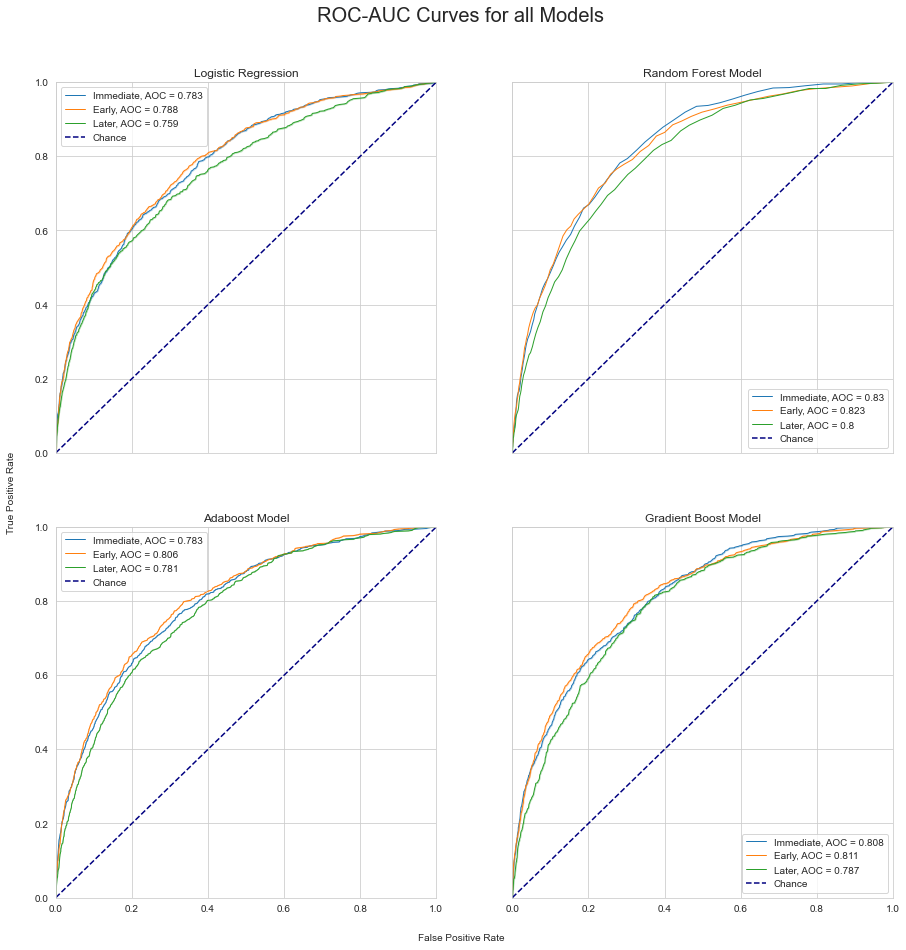

In [116]:
%%capture --no-stdout --no-display

fig, axs = plt.subplots(2, 2, figsize = (15,15), sharex = True, sharey = True)
fig.suptitle('ROC-AUC Curves for all Models', size = 20, y = 0.95)

sns.lineplot(classifiers_immediate['Logistic Regression'][1], \
               classifiers_immediate['Logistic Regression'][2], \
               ax=axs[0, 0], \
               label = "Immediate, AOC = {}".format(classifiers_immediate['Logistic Regression'][0]), linewidth = 1)
sns.lineplot(classifiers_early['Logistic Regression'][1], \
               classifiers_early['Logistic Regression'][2], \
               ax=axs[0, 0], \
               label = "Early, AOC = {}".format(classifiers_early['Logistic Regression'][0]), linewidth = 1)
sns.lineplot(classifiers_later['Logistic Regression'][1], \
               classifiers_later['Logistic Regression'][2], \
               ax=axs[0, 0], \
               label = "Later, AOC = {}".format(classifiers_later['Logistic Regression'][0]), linewidth = 1)
sns.lineplot([0, 1], [0, 1], color='navy', linestyle='--', label = "Chance", ax = axs[0,0])
axs[0, 0].set_title("Logistic Regression")



sns.lineplot(classifiers_immediate['Random Forest Model'][1], \
               classifiers_immediate['Random Forest Model'][2], \
               ax=axs[0, 1], \
               label = "Immediate, AOC = {}".format(classifiers_immediate['Random Forest Model'][0]), linewidth = 1)
sns.lineplot(classifiers_early['Random Forest Model'][1], \
               classifiers_early['Random Forest Model'][2], \
               ax=axs[0, 1], \
               label = "Early, AOC = {}".format(classifiers_early['Random Forest Model'][0]), linewidth = 1)
sns.lineplot(classifiers_later['Random Forest Model'][1], \
               classifiers_later['Random Forest Model'][2], \
               ax=axs[0, 1], \
               label = "Later, AOC = {}".format(classifiers_later['Random Forest Model'][0]), linewidth = 1)
sns.lineplot([0, 1], [0, 1], color='navy', linestyle='--', label = "Chance", ax = axs[0,1])
axs[0, 1].set_title("Random Forest Model")



sns.lineplot(classifiers_immediate['Adaboost Model'][1], \
               classifiers_immediate['Adaboost Model'][2], \
               ax=axs[1, 0], \
               label = "Immediate, AOC = {}".format(classifiers_immediate['Logistic Regression'][0]), linewidth = 1)
sns.lineplot(classifiers_early['Adaboost Model'][1], \
               classifiers_early['Adaboost Model'][2], \
               ax=axs[1, 0], \
               label = "Early, AOC = {}".format(classifiers_early['Adaboost Model'][0]), linewidth = 1)
sns.lineplot(classifiers_later['Adaboost Model'][1], \
               classifiers_later['Adaboost Model'][2], \
               ax=axs[1, 0], \
               label = "Later, AOC = {}".format(classifiers_later['Adaboost Model'][0]), linewidth = 1)
sns.lineplot([0, 1], [0, 1], color='navy', linestyle='--', label = "Chance", ax = axs[1,0])
axs[1, 0].set_title("Adaboost Model")



sns.lineplot(classifiers_immediate['Gradient Boost Model'][1], \
               classifiers_immediate['Gradient Boost Model'][2], \
               ax=axs[1, 1], \
               label = "Immediate, AOC = {}".format(classifiers_immediate['Gradient Boost Model'][0]), linewidth = 1)
sns.lineplot(classifiers_early['Gradient Boost Model'][1], \
               classifiers_early['Gradient Boost Model'][2], \
               ax=axs[1, 1], \
               label = "Early, AOC = {}".format(classifiers_early['Gradient Boost Model'][0]), linewidth = 1)
sns.lineplot(classifiers_later['Gradient Boost Model'][1], \
               classifiers_later['Gradient Boost Model'][2], \
               ax=axs[1, 1], \
               label = "Later, AOC = {}".format(classifiers_later['Gradient Boost Model'][0]), linewidth = 1)
sns.lineplot([0, 1], [0, 1], color='navy', linestyle='--', label = "Chance", ax = axs[1,1])
axs[1, 1].set_title("Gradient Boost Model")

fig.text(0.5, 0.085, 'False Positive Rate', ha='center')
fig.text(0.08, 0.5, 'True Positive Rate', va='center', rotation='vertical')

plt.xlim(0,1)
plt.ylim(0,1)

plt.show()

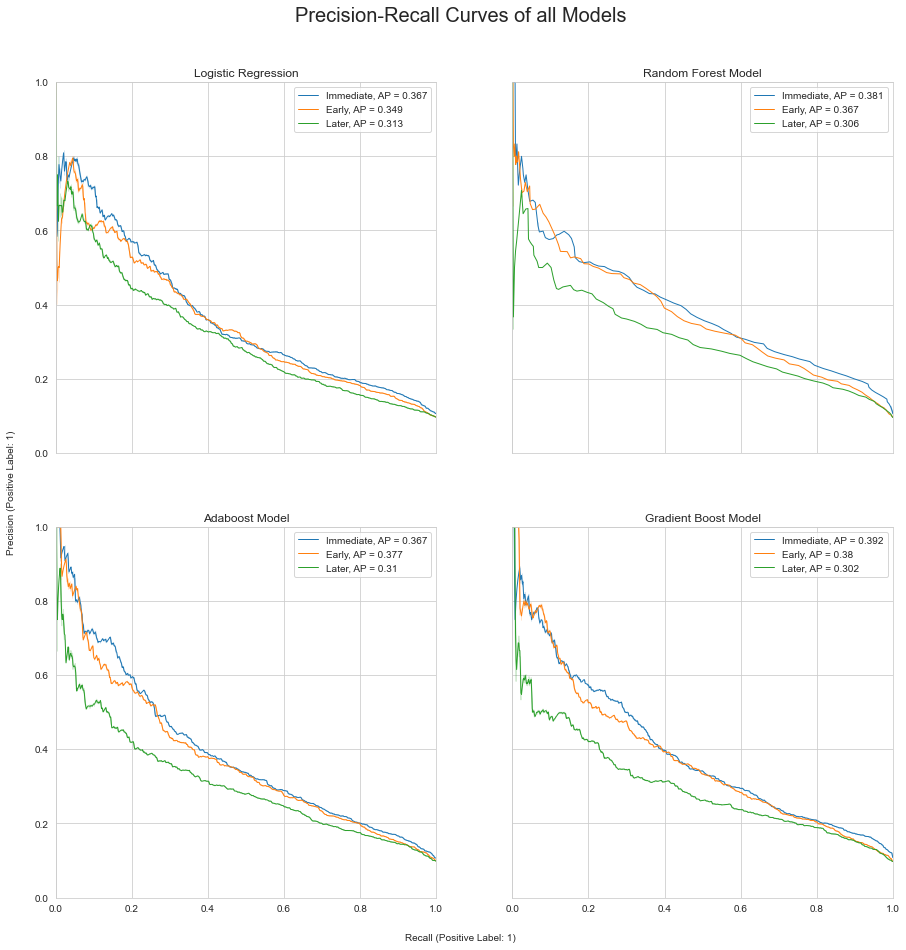

In [117]:
%%capture --no-stdout --no-display

fig, axs = plt.subplots(2, 2, figsize = (15,15), sharex = True, sharey = True)
fig.suptitle('Precision-Recall Curves of all Models', size = 20, y = 0.95)

sns.lineplot(classifiers_immediate['Logistic Regression'][4], \
               classifiers_immediate['Logistic Regression'][3], \
               ax=axs[0, 0], \
               label = "Immediate, AP = {}".format(classifiers_immediate['Logistic Regression'][5]), linewidth = 1)
sns.lineplot(classifiers_early['Logistic Regression'][4], \
               classifiers_early['Logistic Regression'][3], \
               ax=axs[0, 0], \
               label = "Early, AP = {}".format(classifiers_early['Logistic Regression'][5]), linewidth = 1)
sns.lineplot(classifiers_later['Logistic Regression'][4], \
               classifiers_later['Logistic Regression'][3], \
               ax=axs[0, 0], \
               label = "Later, AP = {}".format(classifiers_later['Logistic Regression'][5]), linewidth = 1)
axs[0, 0].set_title("Logistic Regression")



sns.lineplot(classifiers_immediate['Random Forest Model'][4], \
               classifiers_immediate['Random Forest Model'][3], \
               ax=axs[0, 1], \
               label = "Immediate, AP = {}".format(classifiers_immediate['Random Forest Model'][5]), linewidth = 1)
sns.lineplot(classifiers_early['Random Forest Model'][4], \
               classifiers_early['Random Forest Model'][3], \
               ax=axs[0, 1], \
               label = "Early, AP = {}".format(classifiers_early['Random Forest Model'][5]), linewidth = 1)
sns.lineplot(classifiers_later['Random Forest Model'][4], \
               classifiers_later['Random Forest Model'][3], \
               ax=axs[0, 1], \
               label = "Later, AP = {}".format(classifiers_later['Random Forest Model'][5]), linewidth = 1)
axs[0, 1].set_title("Random Forest Model")



sns.lineplot(classifiers_immediate['Adaboost Model'][4], \
               classifiers_immediate['Adaboost Model'][3], \
               ax=axs[1, 0], \
               label = "Immediate, AP = {}".format(classifiers_immediate['Logistic Regression'][5]), linewidth = 1)
sns.lineplot(classifiers_early['Adaboost Model'][4], \
               classifiers_early['Adaboost Model'][3], \
               ax=axs[1, 0], \
               label = "Early, AP = {}".format(classifiers_early['Adaboost Model'][5]), linewidth = 1)
sns.lineplot(classifiers_later['Adaboost Model'][4], \
               classifiers_later['Adaboost Model'][3], \
               ax=axs[1, 0], \
               label = "Later, AP = {}".format(classifiers_later['Adaboost Model'][5]), linewidth = 1)
axs[1, 0].set_title("Adaboost Model")



sns.lineplot(classifiers_immediate['Gradient Boost Model'][4], \
               classifiers_immediate['Gradient Boost Model'][3], \
               ax=axs[1, 1], \
               label = "Immediate, AP = {}".format(classifiers_immediate['Gradient Boost Model'][5]), linewidth = 1)
sns.lineplot(classifiers_early['Gradient Boost Model'][4], \
               classifiers_early['Gradient Boost Model'][3], \
               ax=axs[1, 1], \
               label = "Early, AP = {}".format(classifiers_early['Gradient Boost Model'][5]), linewidth = 1)
sns.lineplot(classifiers_later['Gradient Boost Model'][4], \
               classifiers_later['Gradient Boost Model'][3], \
               ax=axs[1, 1], \
               label = "Later, AP = {}".format(classifiers_later['Gradient Boost Model'][5]), linewidth = 1)
axs[1, 1].set_title("Gradient Boost Model")


fig.text(0.5, 0.085, 'Recall (Positive Label: 1)', ha='center')
fig.text(0.08, 0.5, 'Precision (Positive Label: 1)', va='center', rotation='vertical')

plt.xlim(0,1)
plt.ylim(0,1)

plt.show()